In [105]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [106]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

In [107]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

In [108]:
def calculate_change_indices(df):
    change_indices = []
    for i in range(1, len(df)):
        if df.iloc[i]['last_performance'] != df.iloc[i-1]['last_performance']:
            change_indices.append(i)
    return change_indices


def plot_results(y, df_jugador, df_predictions, prediction_index):
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_jugador['Fecha'], df_jugador[y], label='Real', color='blue')
    plt.plot(df_predictions[df_predictions['Predicciones'].notnull()]['Fecha'], df_predictions[df_predictions['Predicciones'].notnull()]['Predicciones'], label='Predicción', color='red')
    plt.scatter(df_jugador.iloc[prediction_index]['Fecha'], df_jugador.iloc[prediction_index][y], color='green', label='Día antes de predicción')
    plt.title(f'Predicción de {y} para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)
    
    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def calculate_errors(df_jugador, df_predictions, y):
    aux = df_predictions[df_predictions['Predicciones'].notnull()]
    aux['Diferencia'] = abs(aux[y] - aux['Predicciones'])

    mean_error_todos = np.mean(aux['Diferencia'])
    std_error_todos = np.std(aux['Diferencia'])
    min_error_todos = np.min(aux['Diferencia'])
    max_error_todos = np.max(aux['Diferencia'])
    median_todos = np.median(aux['Diferencia'])

    change_indices = calculate_change_indices(df_jugador)

    match_days = df_jugador.iloc[np.array(change_indices)]['Fecha']
    errors_match_days = aux[aux['Fecha'].isin(match_days)]['Diferencia']

    mean_error_dia_partido = np.mean(errors_match_days)
    std_error_dia_partido = np.std(errors_match_days)
    min_error_dia_partido = np.min(errors_match_days)
    max_error_dia_partido = np.max(errors_match_days)
    median_dia_partido = np.median(errors_match_days)


    before_match_days = df_jugador.iloc[np.array(change_indices) - 1]['Fecha']
    errors_before_match_days = aux[aux['Fecha'].isin(before_match_days)]['Diferencia']

    mean_error_dia_antes_partido = np.mean(errors_before_match_days)
    std_error_dia_antes_partido = np.std(errors_before_match_days)
    min_error_dia_antes_partido = np.min(errors_before_match_days)
    max_error_dia_antes_partido = np.max(errors_before_match_days)
    median_dia_antes_partido = np.median(errors_before_match_days)

    print("______Todos los días____________")
    print(f"Mean error todos: {mean_error_todos}")
    print(f"Std error todos: {std_error_todos}")
    print(f"Min error todos: {min_error_todos}")
    print(f"Max error todos: {max_error_todos}")
    print(f"Median error todos: {median_todos}\n")

    print("______Días de partido___________")
    print(f"Mean error dia partido: {mean_error_dia_partido}")
    print(f"Std error dia partido: {std_error_dia_partido}")
    print(f"Min error dia partido: {min_error_dia_partido}")
    print(f"Max error dia partido: {max_error_dia_partido}")
    print(f"Median error dia partido: {median_dia_partido}\n")

    print("______Días antes de partido_____")
    print(f"Mean error dia antes partido: {mean_error_dia_antes_partido}")
    print(f"Std error dia antes partido: {std_error_dia_antes_partido}")
    print(f"Min error dia antes partido: {min_error_dia_antes_partido}")
    print(f"Max error dia antes partido: {max_error_dia_antes_partido}")
    print(f"Median error dia antes partido: {median_dia_antes_partido}")

In [109]:
def evaluate_model(df_jugador, config):
    '''
    Evaluar el modelo para un jugador con la configuración dada

    Parámetros:
    - df_jugador: DataFrame con los datos del jugador
    - config: Diccionario con la configuración del modelo
        - order: (p,d,q) del modelo SARIMA
        - seasonal_order: (P,D,Q,s) del modelo SARIMA
        - y: Serie a predecir
        - exog: Serie exógena
        - exog_options: Opciones de la serie exógena:
            - 'no_future': No se incluyen los datos futuros. Propaga el último valor conocido
        - pred_options: Opciones de predicción: 
            - 'matches': Predice los días de partido
            - 'one': Predice a partir de un día hasta el final
            - 'step': Predice cada n días
        - step_options: Si pred_options es 'matches', opciones de predicción:
            - 'next_match': Predice los días hasta el siguiente partido
            - 'next_day': Predice solo un día (el del partido)
        - train_size: Si pred_options es 'one', porcentaje de datos a partir del cual se empieza a predecir
        - step: Si pred_options es 'step', cada cuántos días se predice y número de días a predecir

    Devuelve:
    - df_predictions: DataFrame con las predicciones
    '''

    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    exog = config['exog']
    exog_options = config['exog_options']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            test_data = df_jugador.iloc[matchday:]
            
            days_to_next_match = next_matchday - matchday
            
            modelo = SARIMAX(train_data[y], 
                                exog=train_data[exog],
                                order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                                exog=test_data[exog][:days_to_next_match], dynamic=False)
                
                if exog_options == 'no_future':
                    pred_exog = [train_data.iloc[-1][exog]]*days_to_next_match
                    
                    predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                                exog=pred_exog, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday,
                                                exog=test_data[exog][:1], dynamic=False)
                
                if exog_options == 'no_future':
                    pred_exog = [train_data.iloc[-1][exog]]
                    
                    predicciones = resultado.predict(start=matchday, end=matchday,
                                                exog=pred_exog, dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=test_data[exog], dynamic=False)

        if exog_options == 'no_future':
            pred_exog = [train_data.iloc[-1][exog]]*len(test_data)
            
            predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=pred_exog, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step, exog=df_jugador[exog][i:i+step])

            if exog_options == 'no_future':
                pred_exog = [train_data.iloc[-1][exog]]*step
                
                predicciones = resultado.forecast(steps=step, exog=pred_exog)
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)


def evaluate_model_no_exog(df_jugador, config):
    
    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday, dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step)
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)

A continuación hemos realizado predicciones del sentimiento acumulado (métrica obtenida a través del sentimiento de las noticias), de cada jugador durante el tiempo. Para cada jugador realizamos 2 predicciones, usando una serie exógena (rendimiento del jugador) y otra no por cada predicción, una se realiza sobre el último 30% de los datos, y el otro sobre todos los datos pero prediciendo de 7 en 7 días utilizando solo información anterior.
 
Para estas predicciones hemos tomado las p, d y q que mejor resultados nos devuelven, al igual que los periodos de estacionalidad, donde en algún caso se corresponden a los periodos de la serie exógena, de rendimiento.

### Ferrán

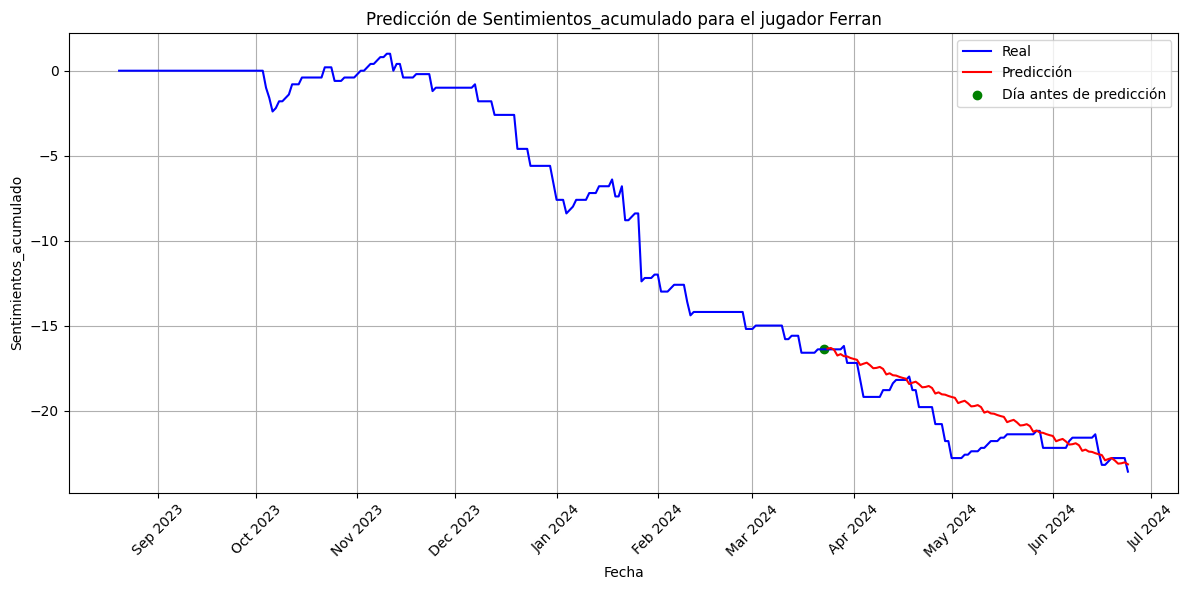

______Todos los días____________
Mean error todos: 1.0437796160251462
Std error todos: 0.9321074660425159
Min error todos: 0.0021028099862760996
Max error todos: 3.5960513443217152
Median error todos: 0.7135589435168832

______Días de partido___________
Mean error dia partido: 1.0325499354848613
Std error dia partido: 0.9953812952917969
Min error dia partido: 0.11910698272690468
Max error dia partido: 3.312888457252516
Median error dia partido: 0.4756952805455654

______Días antes de partido_____
Mean error dia antes partido: 1.1037216517734119
Std error dia antes partido: 0.8823049676084721
Min error dia antes partido: 0.0021028099862760996
Max error dia antes partido: 3.2367469480902145
Median error dia antes partido: 0.9918546179511836


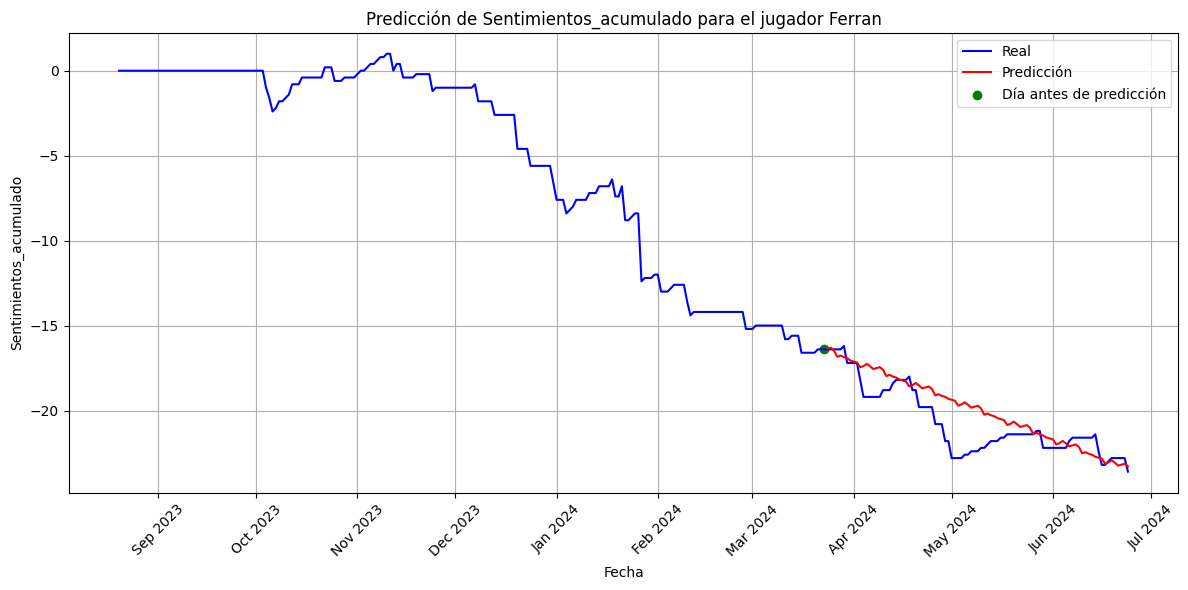

______Todos los días____________
Mean error todos: 0.9873412203400005
Std error todos: 0.9025365942007819
Min error todos: 0.014344213392909921
Max error todos: 3.430149608714906
Median error todos: 0.6129827591813282

______Días de partido___________
Mean error dia partido: 0.9644170152938193
Std error dia partido: 0.9507001794562868
Min error dia partido: 0.014344213392909921
Max error dia partido: 3.1516531597644963
Median error dia partido: 0.39816115965519927

______Días antes de partido_____
Mean error dia antes partido: 1.0648063603576325
Std error dia antes partido: 0.8416000660052197
Min error dia antes partido: 0.02344632222760623
Max error dia antes partido: 3.0853475657818237
Median error dia antes partido: 0.8974697786204935


In [110]:
players = df['Player'].unique()

jugador = players[0]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,15),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

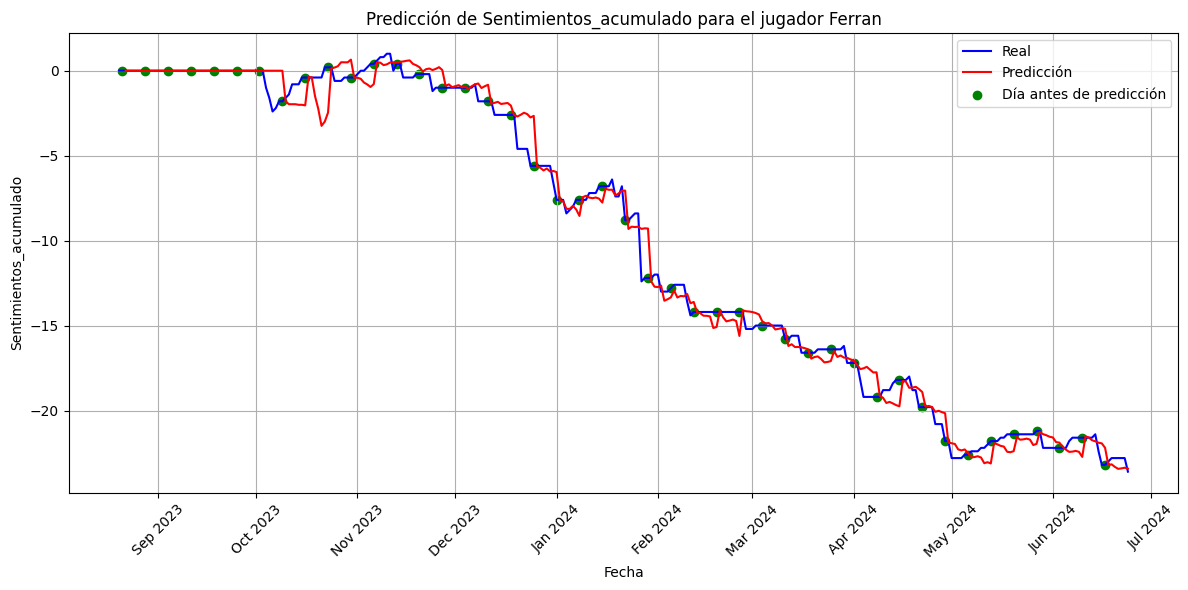

______Todos los días____________
Mean error todos: 0.5841429262266296
Std error todos: 0.6304783058589889
Min error todos: 0.0
Max error todos: 3.1940480854422617
Median error todos: 0.4470194898169497

______Días de partido___________
Mean error dia partido: 0.7135967666436552
Std error dia partido: 0.7634778273178892
Min error dia partido: 0.0
Max error dia partido: 3.1940480854422617
Median error dia partido: 0.5038167656401988

______Días antes de partido_____
Mean error dia antes partido: 0.5428418512765031
Std error dia antes partido: 0.6245280671322581
Min error dia antes partido: 0.0
Max error dia antes partido: 2.8457813743751004
Median error dia antes partido: 0.36725951826945646


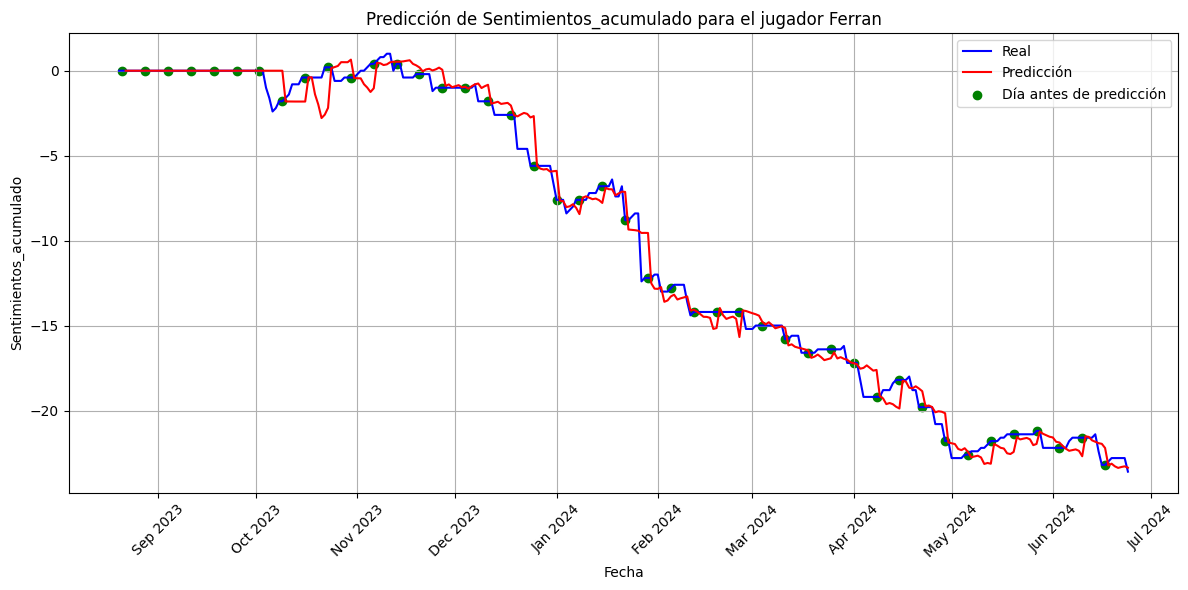

______Todos los días____________
Mean error todos: 0.5773651138094059
Std error todos: 0.6132764464174276
Min error todos: 0.0
Max error todos: 2.928445141448088
Median error todos: 0.38632337750586154

______Días de partido___________
Mean error dia partido: 0.714502618870081
Std error dia partido: 0.7139256857279267
Min error dia partido: 0.0
Max error dia partido: 2.850717685226549
Median error dia partido: 0.5307608552348447

______Días antes de partido_____
Mean error dia antes partido: 0.556353968085115
Std error dia antes partido: 0.6030963667095022
Min error dia antes partido: 0.0
Max error dia antes partido: 2.3863818268131367
Median error dia antes partido: 0.33048912032442956


In [111]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,15),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Gerard Romero

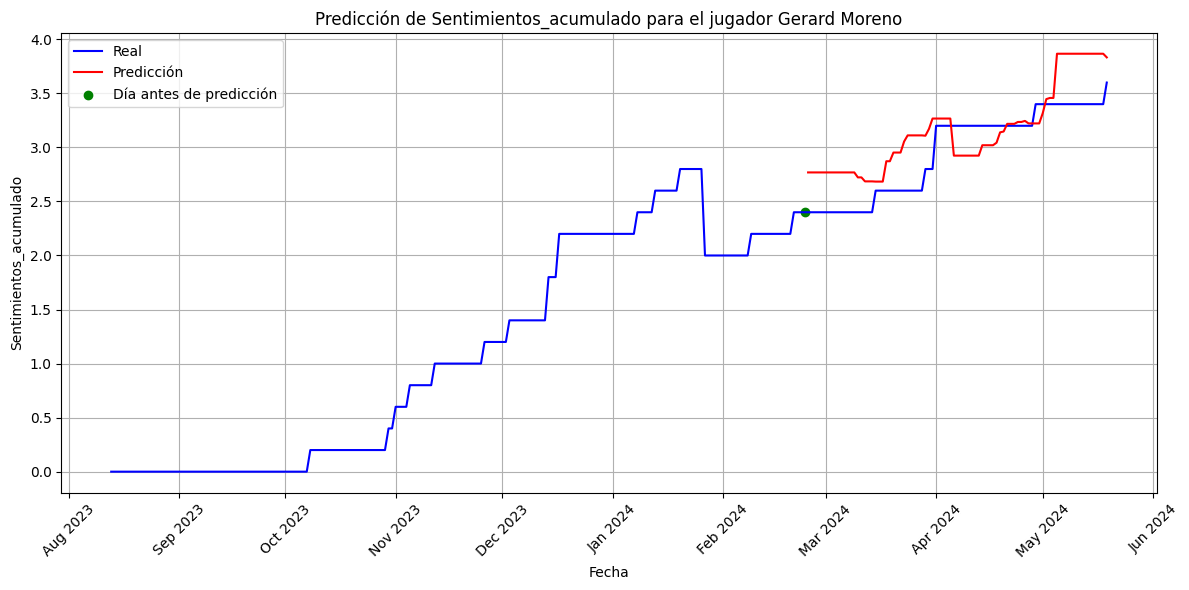

______Todos los días____________
Mean error todos: 0.2797864448134482
Std error todos: 0.1603361283097979
Min error todos: 0.017829511603796977
Max error todos: 0.5111303964484102
Median error todos: 0.2856313101021306

______Días de partido___________
Mean error dia partido: 0.2140479644854498
Std error dia partido: 0.12614724565216917
Min error dia partido: 0.017829511603796977
Max error dia partido: 0.36846045920153214
Median error dia partido: 0.23280822566278658

______Días antes de partido_____
Mean error dia antes partido: 0.304146347922287
Std error dia antes partido: 0.14069442760218298
Min error dia antes partido: 0.05292345194248016
Max error dia antes partido: 0.4670041584906124
Median error dia antes partido: 0.36845987486562626


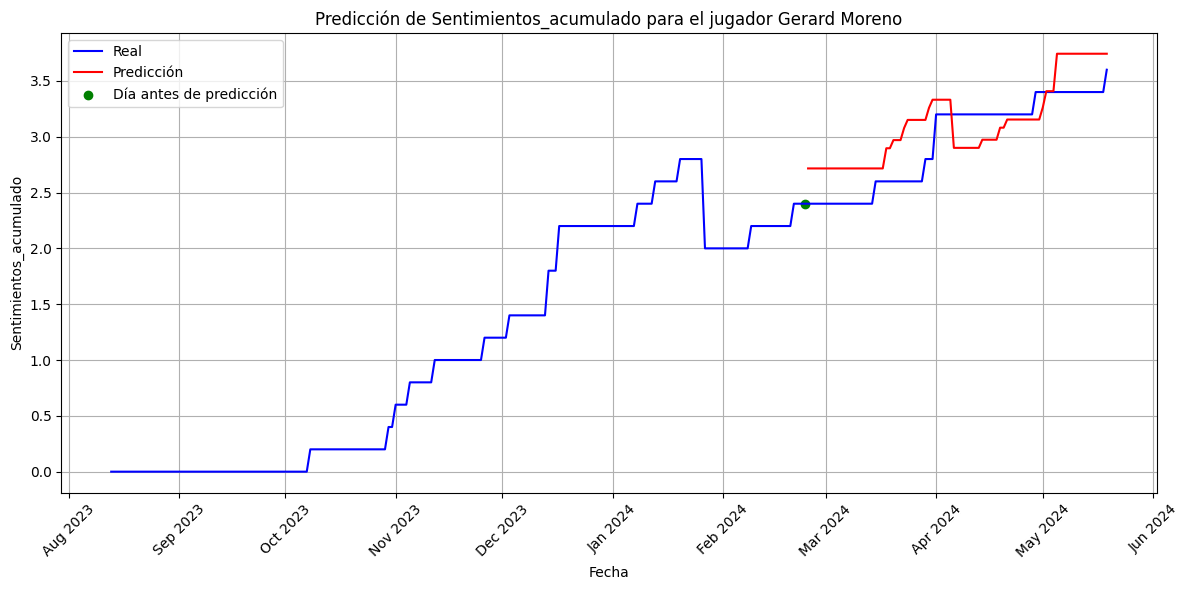

______Todos los días____________
Mean error todos: 0.27084454805217895
Std error todos: 0.13567947120576052
Min error todos: 0.0077732126397376256
Max error todos: 0.5505314266806307
Median error todos: 0.31592731791887463

______Días de partido___________
Mean error dia partido: 0.21412110188276015
Std error dia partido: 0.1007698608598302
Min error dia partido: 0.04603221386702572
Max error dia partido: 0.3159273179233746
Median error dia partido: 0.22683089594843375

______Días antes de partido_____
Mean error dia antes partido: 0.2970114894958732
Std error dia antes partido: 0.1168803140988404
Min error dia antes partido: 0.11592731793472355
Max error dia antes partido: 0.5313301085280395
Median error dia antes partido: 0.3159273179189195


In [112]:
jugador = players[1]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,70),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

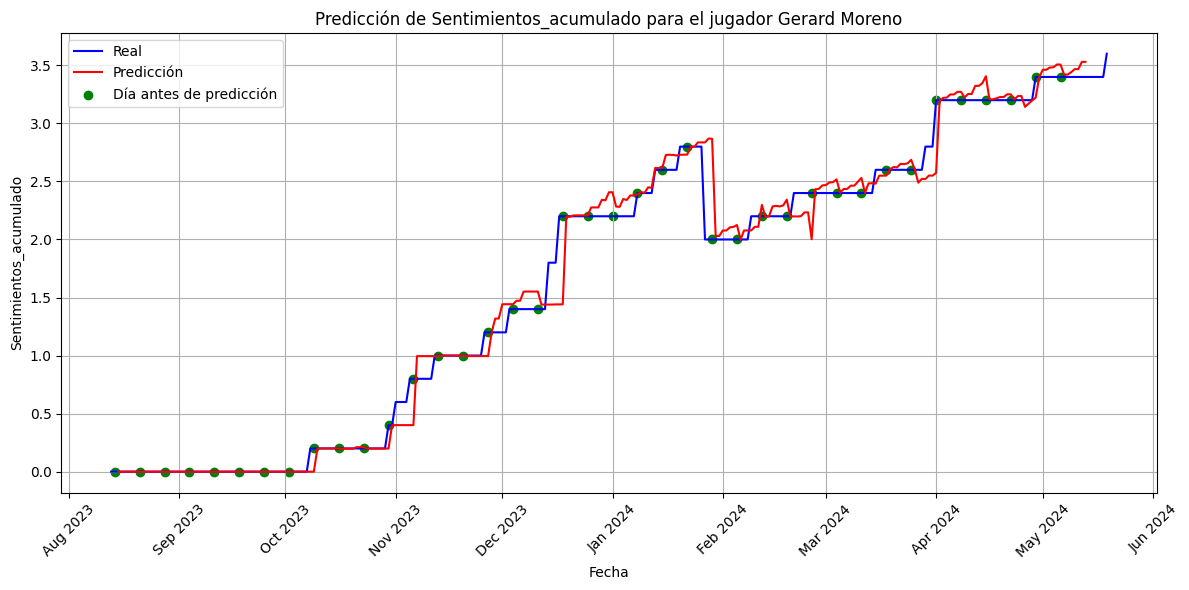

______Todos los días____________
Mean error todos: 0.08090379066021375
Std error todos: 0.1346278630875996
Min error todos: 0.0
Max error todos: 0.8690951859301679
Median error todos: 0.03557375233090454

______Días de partido___________
Mean error dia partido: 0.1529986931376877
Std error dia partido: 0.2072271493124883
Min error dia partido: 0.0
Max error dia partido: 0.8361008572676161
Median error dia partido: 0.08705693871777775

______Días antes de partido_____
Mean error dia antes partido: 0.08947600214552458
Std error dia antes partido: 0.0897244975502384
Min error dia antes partido: 0.0
Max error dia antes partido: 0.35906201539098026
Median error dia antes partido: 0.06818107911761695


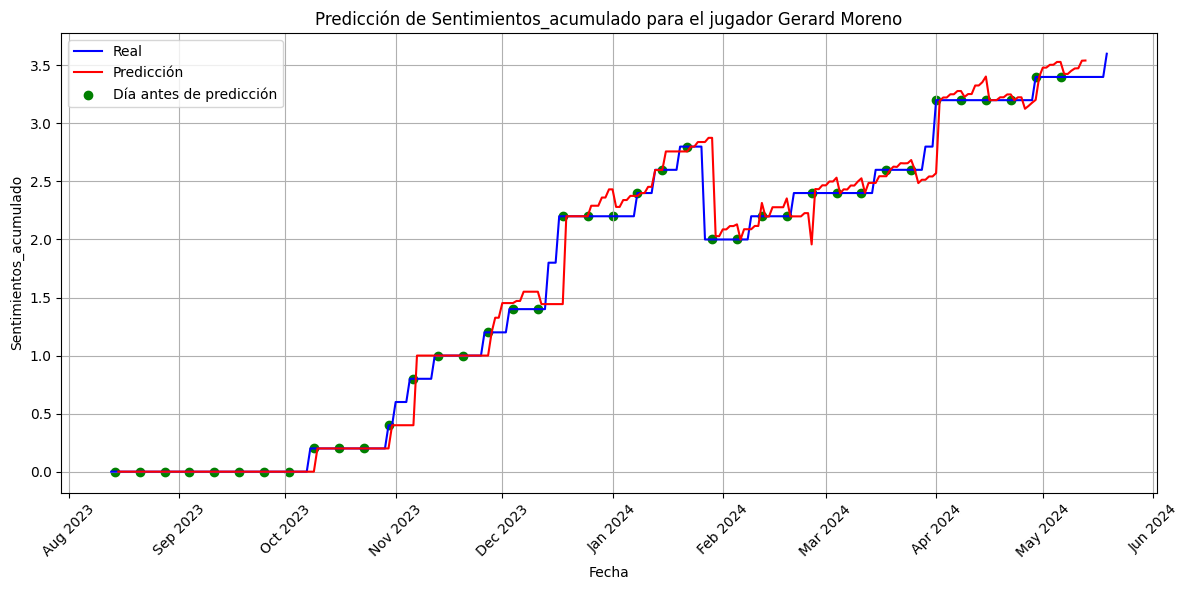

______Todos los días____________
Mean error todos: 0.0826643297439093
Std error todos: 0.13657232438056818
Min error todos: 0.0
Max error todos: 0.8755535671767429
Median error todos: 0.034389723865530186

______Días de partido___________
Mean error dia partido: 0.15169697774653323
Std error dia partido: 0.20834089799933184
Min error dia partido: 0.0
Max error dia partido: 0.8394844056870148
Median error dia partido: 0.08199876277901685

______Días antes de partido_____
Mean error dia antes partido: 0.09216452250968732
Std error dia antes partido: 0.09251760891431016
Min error dia antes partido: 0.0
Max error dia antes partido: 0.3566371288747543
Median error dia antes partido: 0.06730078094726089


In [114]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Griezmann

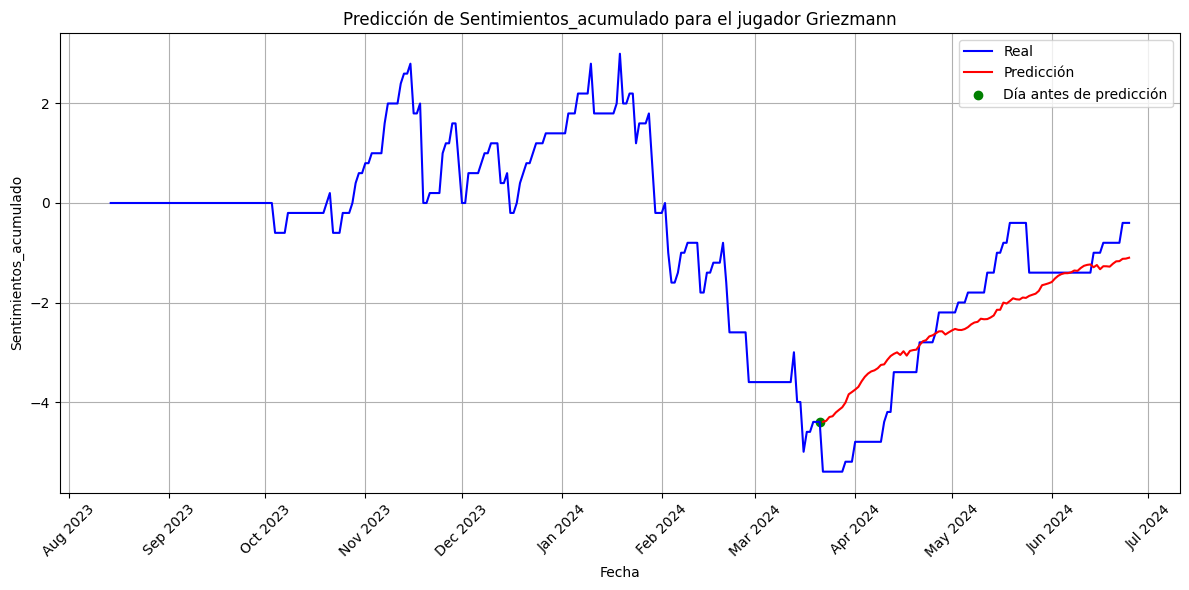

______Todos los días____________
Mean error todos: 0.6656427550399137
Std error todos: 0.48681312148095063
Min error todos: 0.005835898608080425
Max error todos: 1.5711830379908753
Median error todos: 0.4757221241410253

______Días de partido___________
Mean error dia partido: 0.6992745056826364
Std error dia partido: 0.4172805375509208
Min error dia partido: 0.05544675718742731
Max error dia partido: 1.5711830379908753
Median error dia partido: 0.47095061852399556

______Días antes de partido_____
Mean error dia antes partido: 0.8064417920401937
Std error dia antes partido: 0.4865068240840569
Min error dia antes partido: 0.020519733343182356
Max error dia antes partido: 1.5455522850275196
Median error dia antes partido: 0.7182722040263413


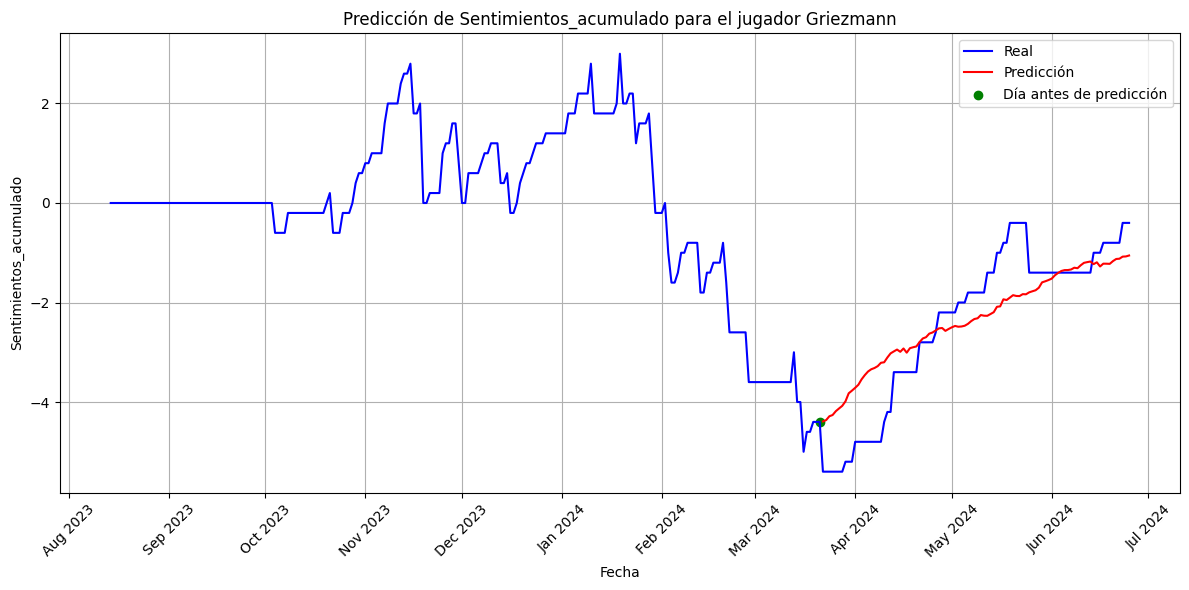

______Todos los días____________
Mean error todos: 0.6522848258446693
Std error todos: 0.48797601457195344
Min error todos: 0.004187679718502757
Max error todos: 1.5882598148563178
Median error todos: 0.47151565034042564

______Días de partido___________
Mean error dia partido: 0.6733751030090747
Std error dia partido: 0.4187366643516669
Min error dia partido: 0.005290112881559228
Max error dia partido: 1.502417139483887
Median error dia partido: 0.47594860388984106

______Días antes de partido_____
Mean error dia antes partido: 0.794038546017238
Std error dia antes partido: 0.48731624030419174
Min error dia antes partido: 0.03851580132924859
Max error dia antes partido: 1.5882598148563178
Median error dia antes partido: 0.6742652317102603


In [115]:
players = df['Player'].unique()

jugador = players[2]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,0,1),
    'seasonal_order': (1,0,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

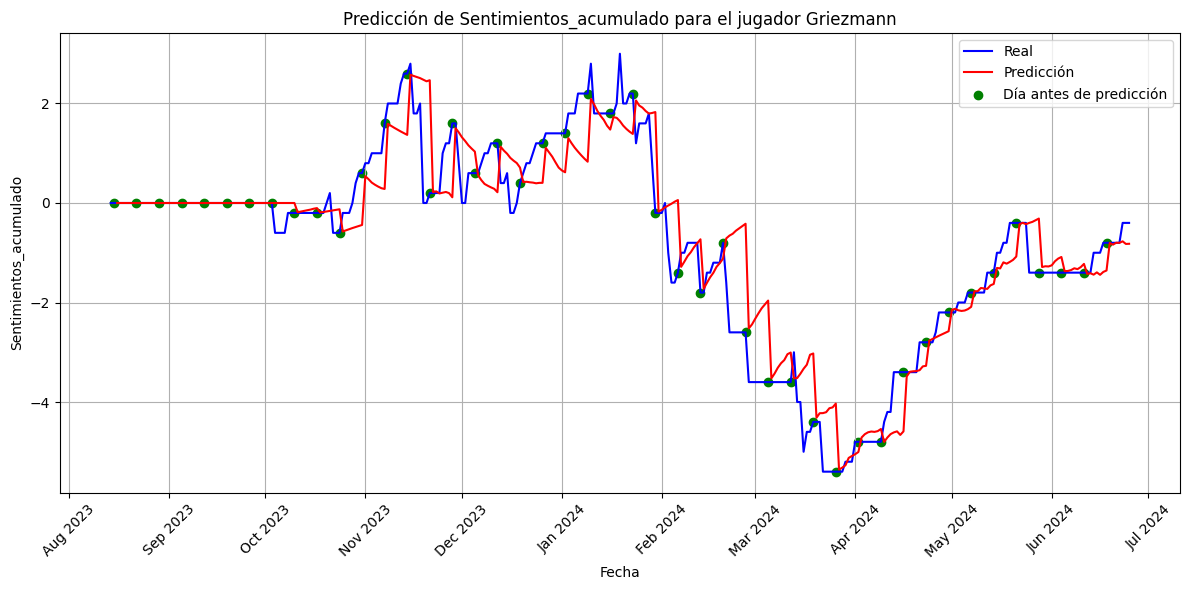

______Todos los días____________
Mean error todos: 0.4731905314645266
Std error todos: 0.5296954103275225
Min error todos: 1.5615654000098475e-06
Max error todos: 2.4766711507014985
Median error todos: 0.31504600364773605

______Días de partido___________
Mean error dia partido: 0.5423592026995323
Std error dia partido: 0.4442372718154256
Min error dia partido: 1.5615654000141728e-06
Max error dia partido: 1.5850396453461064
Median error dia partido: 0.4976979360746694

______Días antes de partido_____
Mean error dia antes partido: 0.43563897091292003
Std error dia antes partido: 0.4643982907591024
Min error dia antes partido: 1.5615654000098475e-06
Max error dia antes partido: 2.027767356595273
Median error dia antes partido: 0.38349846414612015


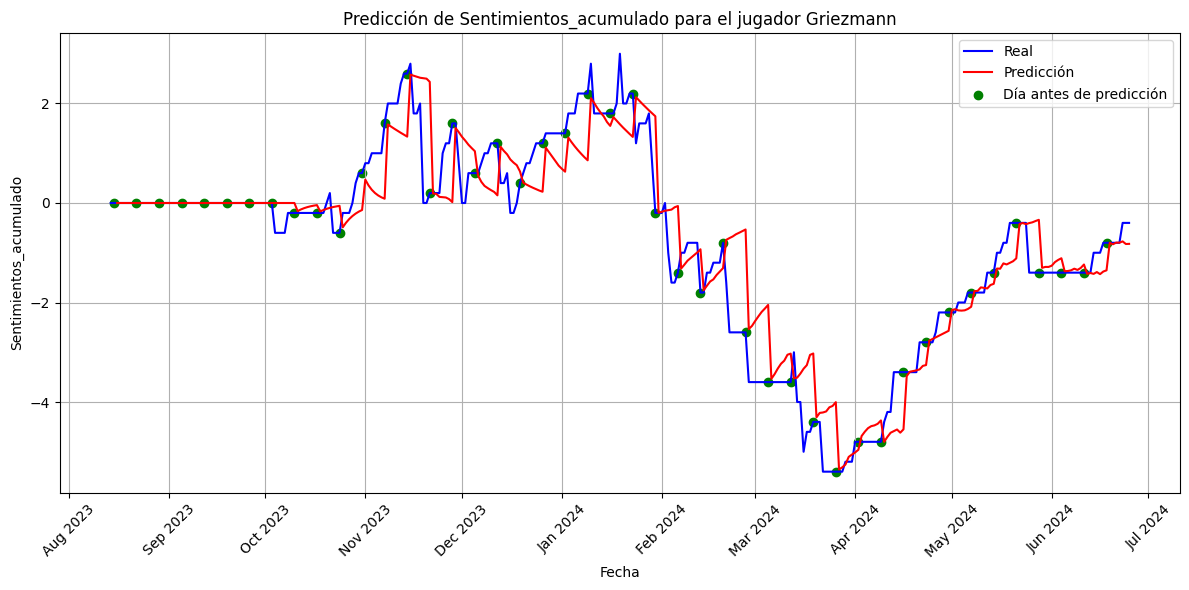

______Todos los días____________
Mean error todos: 0.47928957052494
Std error todos: 0.5200170666661377
Min error todos: 0.0
Max error todos: 2.5079357229102928
Median error todos: 0.32070706161774776

______Días de partido___________
Mean error dia partido: 0.5512212907051743
Std error dia partido: 0.448369228684745
Min error dia partido: 0.0
Max error dia partido: 1.5825049908680513
Median error dia partido: 0.5100158607078225

______Días antes de partido_____
Mean error dia antes partido: 0.4530198315943022
Std error dia antes partido: 0.45656900070464734
Min error dia antes partido: 0.0
Max error dia antes partido: 1.9425286459941045
Median error dia antes partido: 0.417672509238427


In [116]:
config = {
    'order': (1,0,1),
    'seasonal_order': (1,0,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Koundé

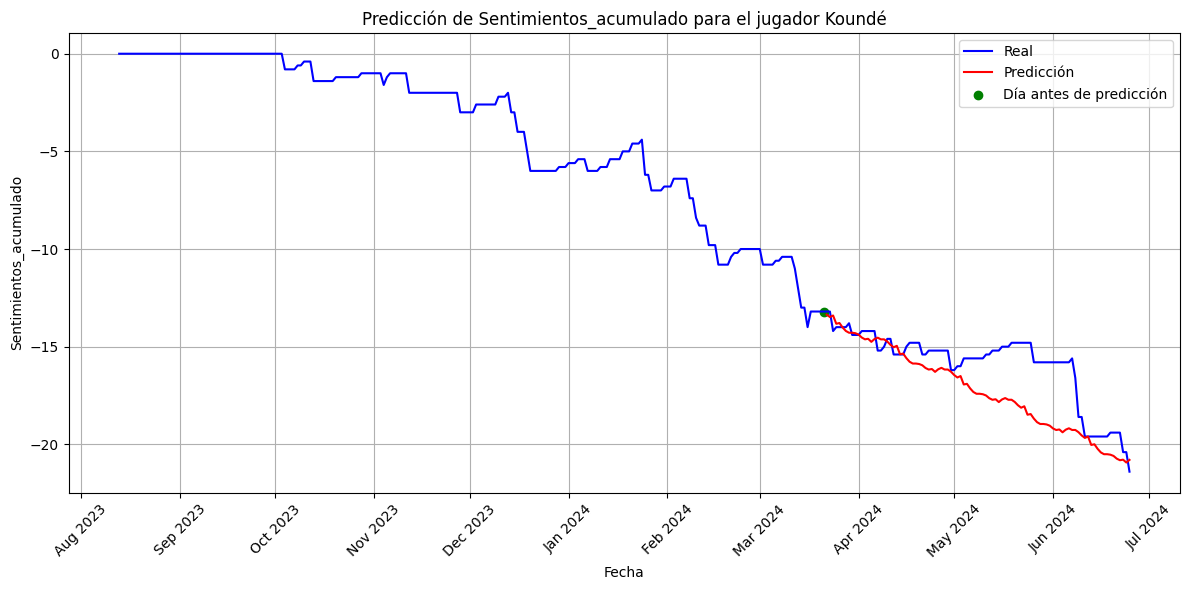

______Todos los días____________
Mean error todos: 1.4005244774114545
Std error todos: 1.1891097013635883
Min error todos: 0.0008245961944375324
Max error todos: 3.683725849942636
Median error todos: 0.962417463136191

______Días de partido___________
Mean error dia partido: 1.2859974724993886
Std error dia partido: 0.9960025403328294
Min error dia partido: 0.11358990915275413
Max error dia partido: 2.917107385826739
Median error dia partido: 0.9378480645171301

______Días antes de partido_____
Mean error dia antes partido: 1.258807360013808
Std error dia antes partido: 1.060978705734364
Min error dia antes partido: 0.044934285678408514
Max error dia antes partido: 3.649978304207906
Median error dia antes partido: 0.8919023880957102


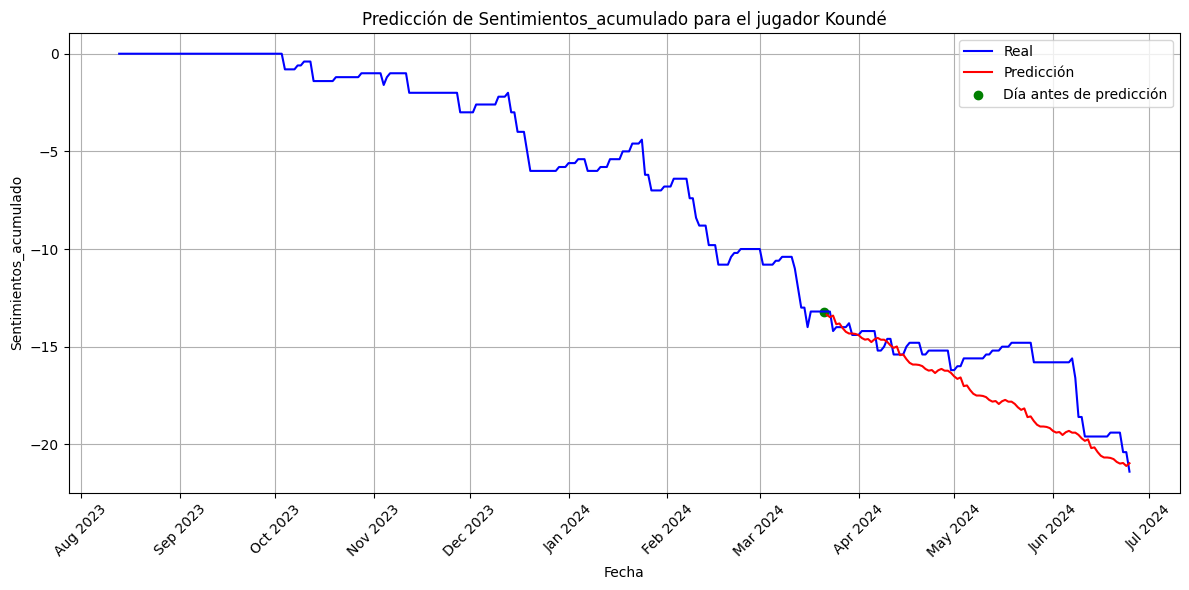

______Todos los días____________
Mean error todos: 1.4772945241307696
Std error todos: 1.222982887263477
Min error todos: 0.0016780314067492696
Max error todos: 3.8064579067400786
Median error todos: 1.0296908416327195

______Días de partido___________
Mean error dia partido: 1.3403053292140203
Std error dia partido: 1.0444516507735508
Min error dia partido: 0.0736306986625781
Max error dia partido: 3.015591207128111
Median error dia partido: 1.0518195562393

______Días antes de partido_____
Mean error dia antes partido: 1.3332604294204955
Std error dia antes partido: 1.0917209285244474
Min error dia antes partido: 0.0016780314067492696
Max error dia antes partido: 3.7710089749801448
Median error dia antes partido: 1.0076216154774773


In [117]:
players = df['Player'].unique()

jugador = players[3]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

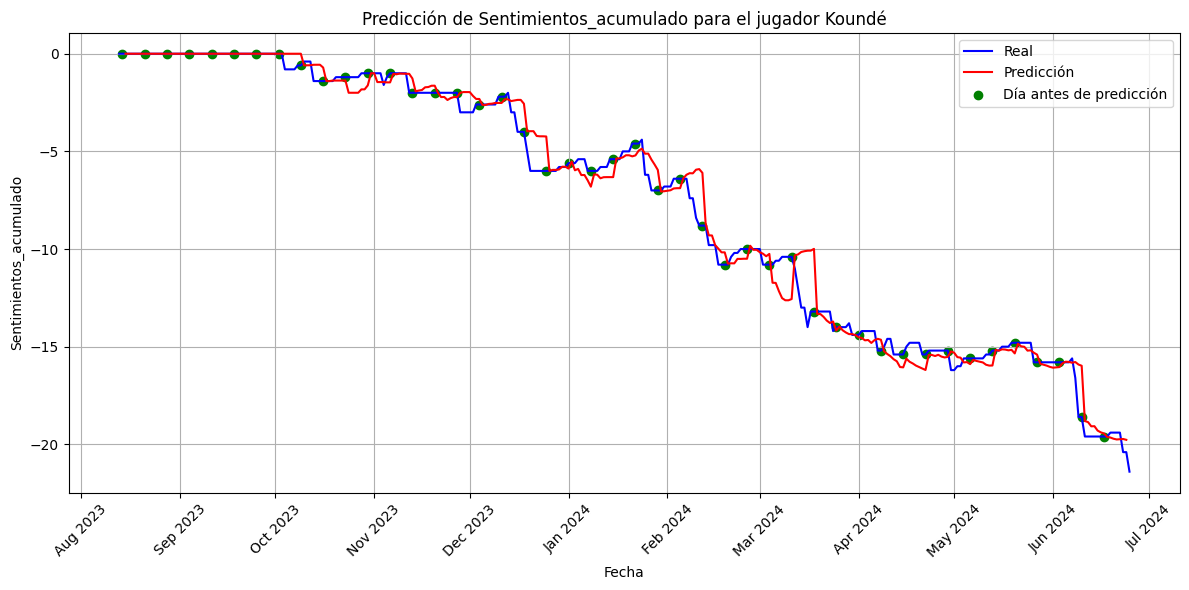

______Todos los días____________
Mean error todos: 0.4989835334572748
Std error todos: 0.6410541528900442
Min error todos: 0.0
Max error todos: 3.9145742552100877
Median error todos: 0.28403398534747115

______Días de partido___________
Mean error dia partido: 0.6314566643303141
Std error dia partido: 0.7252177181552459
Min error dia partido: 0.0
Max error dia partido: 3.1183389013311924
Median error dia partido: 0.3973013163030039

______Días antes de partido_____
Mean error dia antes partido: 0.5140086077033383
Std error dia antes partido: 0.7486943185994388
Min error dia antes partido: 0.0
Max error dia antes partido: 3.9145742552100877
Median error dia antes partido: 0.2439648707416211


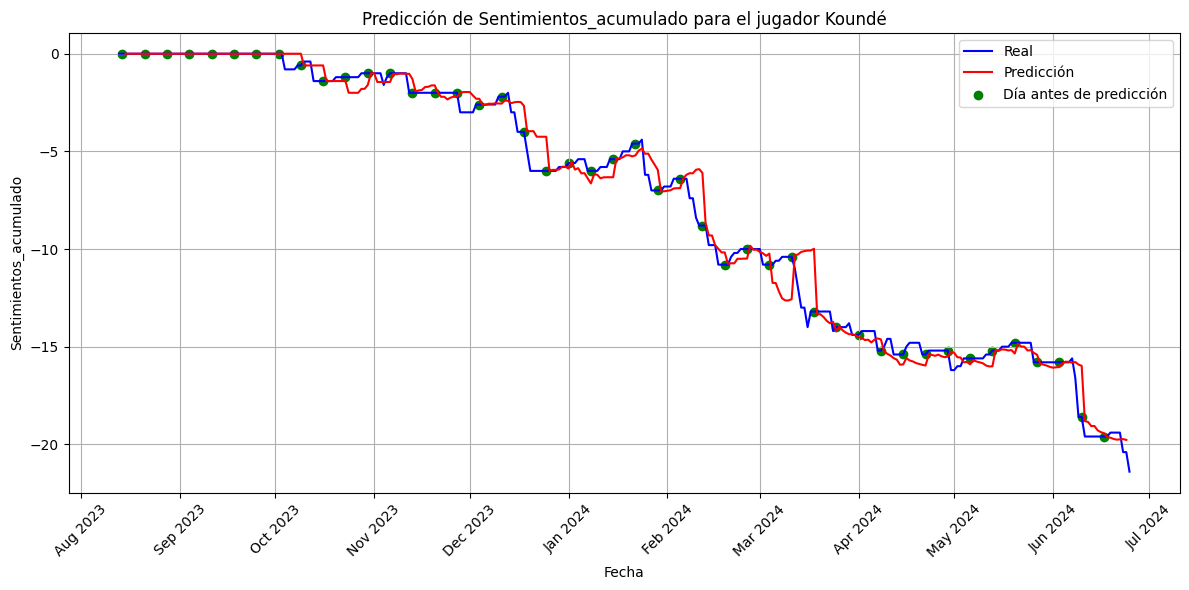

______Todos los días____________
Mean error todos: 0.4926717006718554
Std error todos: 0.6369590380786897
Min error todos: 0.0
Max error todos: 3.9217256521181802
Median error todos: 0.2922626228460725

______Días de partido___________
Mean error dia partido: 0.6253625049371453
Std error dia partido: 0.7229293088449278
Min error dia partido: 0.0
Max error dia partido: 3.1238386128294007
Median error dia partido: 0.4334401342056762

______Días antes de partido_____
Mean error dia antes partido: 0.5061766872960884
Std error dia antes partido: 0.7471059068120822
Min error dia antes partido: 0.0
Max error dia antes partido: 3.9217256521181802
Median error dia antes partido: 0.23366439485245216


In [118]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Kubo

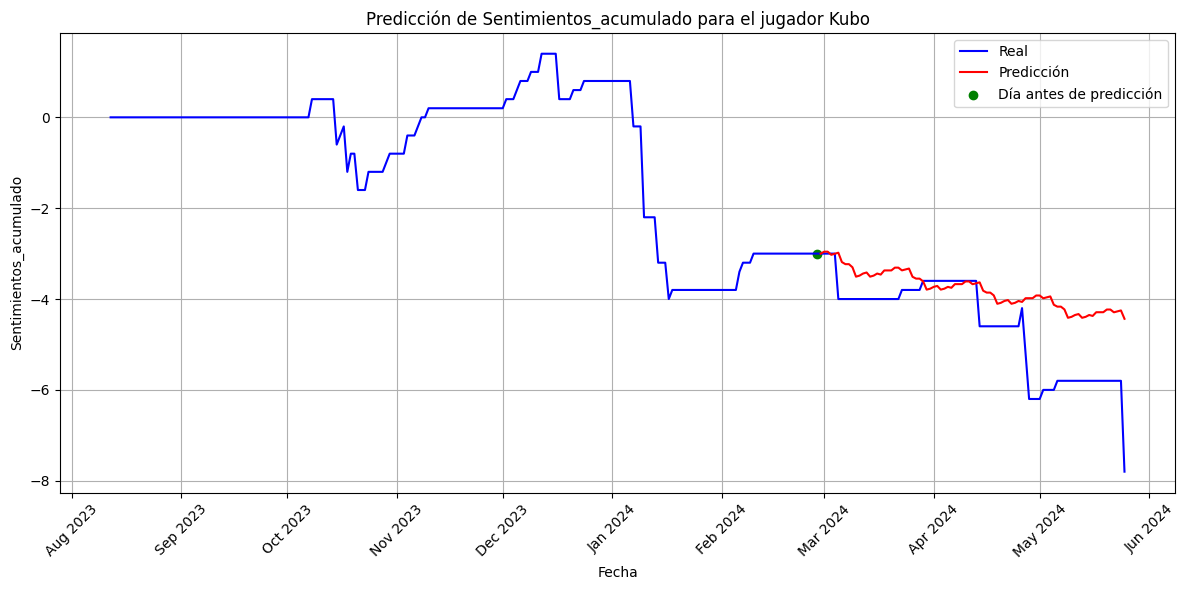

______Todos los días____________
Mean error todos: 0.8425263046747835
Std error todos: 0.7109882787698895
Min error todos: 0.0003608420726091133
Max error todos: 3.365085804833301
Median error todos: 0.6297496360010686

______Días de partido___________
Mean error dia partido: 1.1607558425228333
Std error dia partido: 0.9300489277439886
Min error dia partido: 0.1366938682399672
Max error dia partido: 3.365085804833301
Median error dia partido: 0.9935814663495461

______Días antes de partido_____
Mean error dia antes partido: 0.8319633448036872
Std error dia antes partido: 0.6888580319628108
Min error dia antes partido: 0.0031993269804622138
Max error dia antes partido: 2.0372149725652027
Median error dia antes partido: 0.5368487818927794


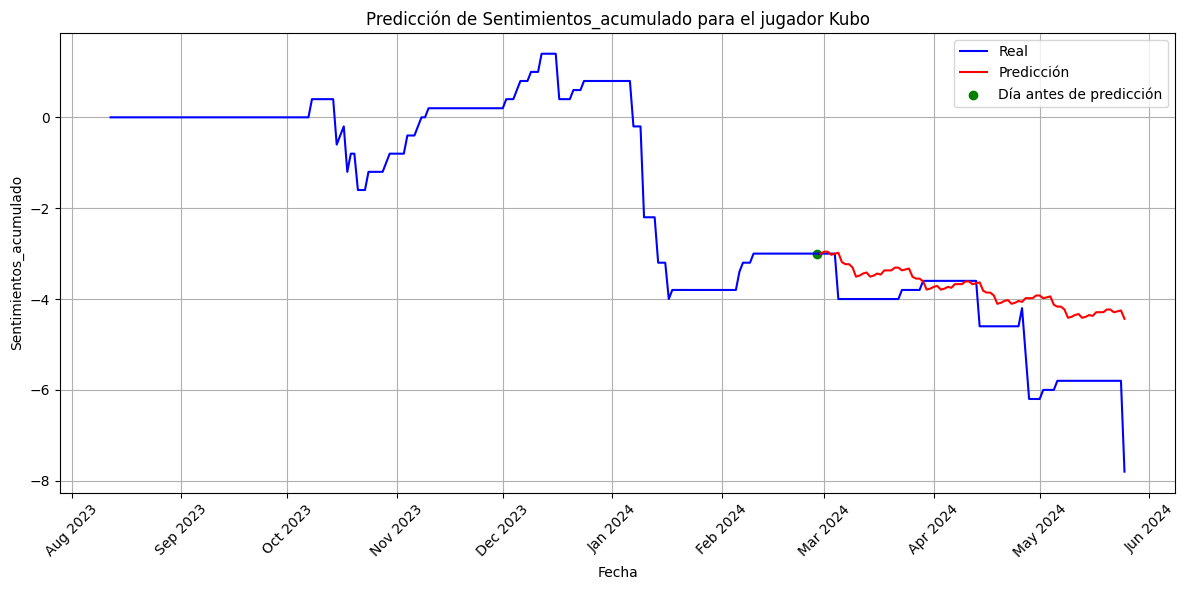

______Todos los días____________
Mean error todos: 0.8426233278531771
Std error todos: 0.71106456403667
Min error todos: 0.0002156990798449776
Max error todos: 3.365018954722439
Median error todos: 0.6302449598272957

______Días de partido___________
Mean error dia partido: 1.1607974002781722
Std error dia partido: 0.9300193910993675
Min error dia partido: 0.13704360953777428
Max error dia partido: 3.365018954722439
Median error dia partido: 0.9933773994265445

______Días antes de partido_____
Mean error dia antes partido: 0.8320348661178434
Std error dia antes partido: 0.6889102968879247
Min error dia antes partido: 0.003300642409271859
Max error dia antes partido: 2.0373171946933364
Median error dia antes partido: 0.5370939433130979


In [119]:
players = df['Player'].unique()

jugador = players[4]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

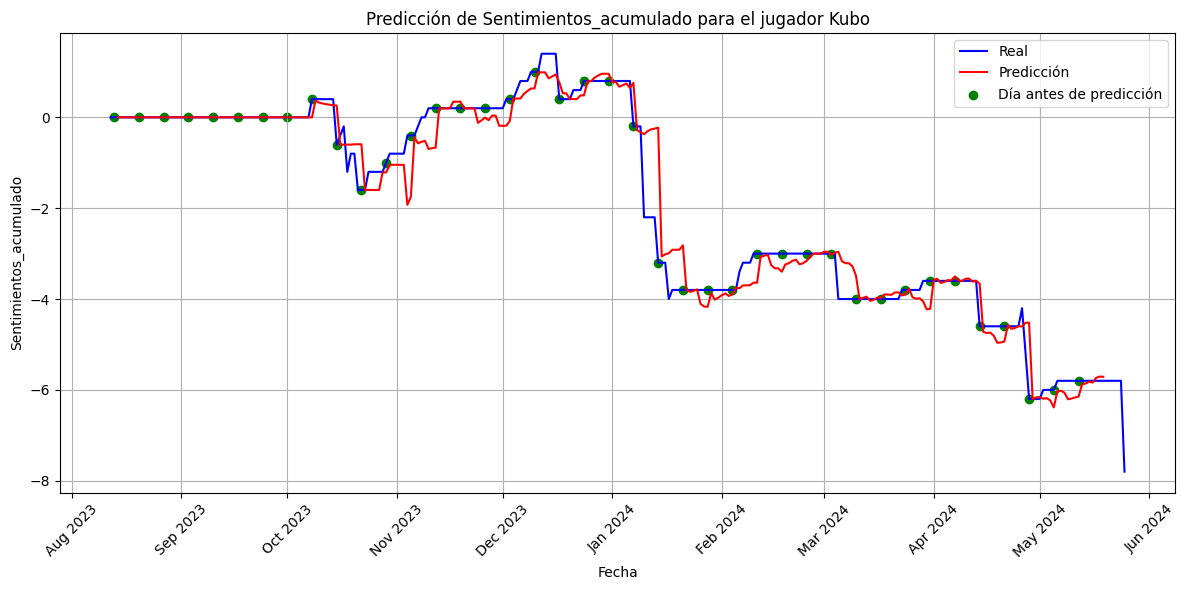

______Todos los días____________
Mean error todos: 0.24422142087592386
Std error todos: 0.38245881192253883
Min error todos: 0.0
Max error todos: 2.972447878781658
Median error todos: 0.11762389976145521

______Días de partido___________
Mean error dia partido: 0.34078935484499207
Std error dia partido: 0.3645433251816668
Min error dia partido: 0.0
Max error dia partido: 1.526421651187933
Median error dia partido: 0.23499327847795093

______Días antes de partido_____
Mean error dia antes partido: 0.16271613158745749
Std error dia antes partido: 0.21371229364791725
Min error dia antes partido: 0.0
Max error dia antes partido: 0.897048900709659
Median error dia antes partido: 0.030675092694736783


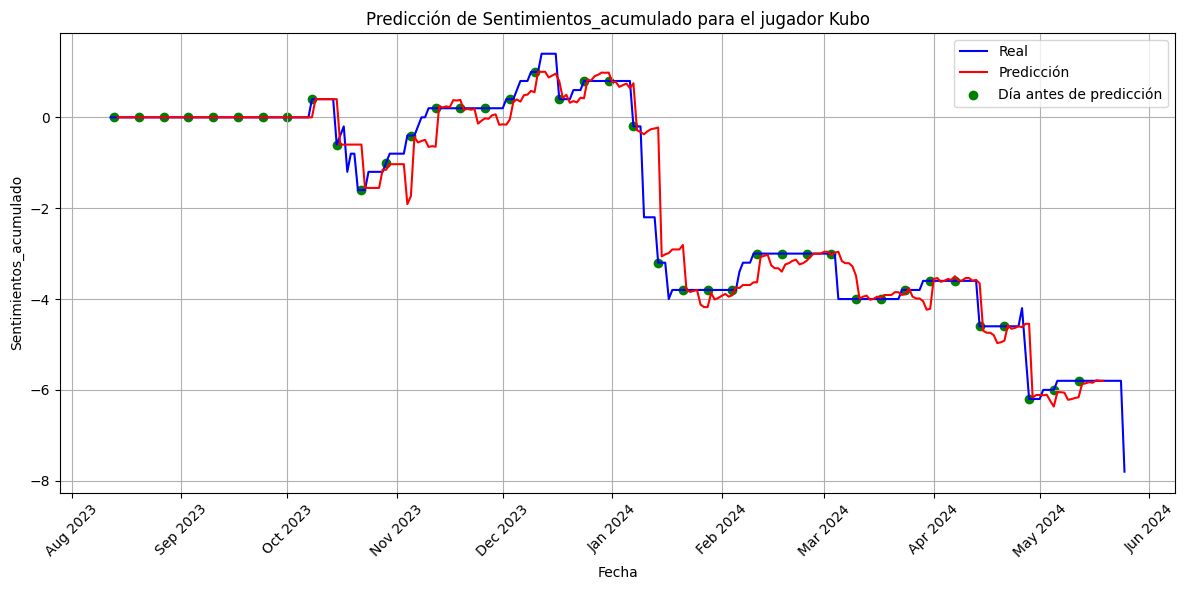

______Todos los días____________
Mean error todos: 0.2436724480010886
Std error todos: 0.38225676067394854
Min error todos: 0.0
Max error todos: 2.9759123268491114
Median error todos: 0.09693795736847005

______Días de partido___________
Mean error dia partido: 0.3378247570912047
Std error dia partido: 0.36121362688426156
Min error dia partido: 0.0
Max error dia partido: 1.5105317206530202
Median error dia partido: 0.2433491072880472

______Días antes de partido_____
Mean error dia antes partido: 0.16375926905524485
Std error dia antes partido: 0.20617484176990147
Min error dia antes partido: 0.0
Max error dia antes partido: 0.8506705760253317
Median error dia antes partido: 0.04921549406312886


In [120]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Lamine Yamal

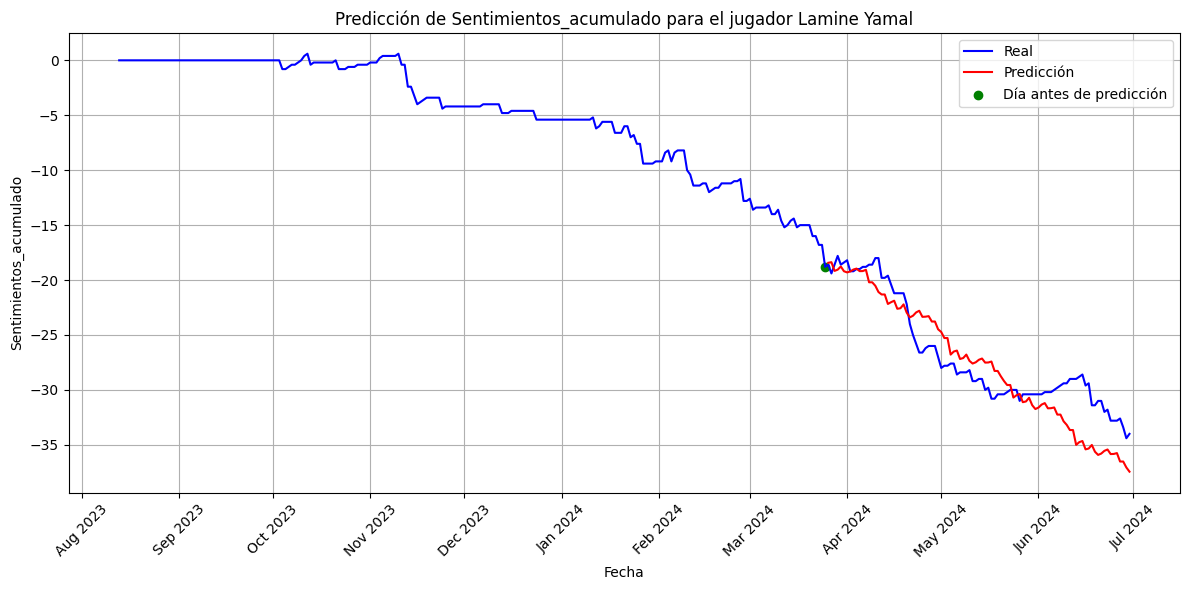

______Todos los días____________
Mean error todos: 2.1141917793411804
Std error todos: 1.4978432395154933
Min error todos: 0.017241200457771555
Max error todos: 6.0522313889871455
Median error todos: 1.6397694934208467

______Días de partido___________
Mean error dia partido: 2.184689723273686
Std error dia partido: 1.604962807314292
Min error dia partido: 0.1677044591547876
Max error dia partido: 6.0522313889871455
Median error dia partido: 2.1255128340462264

______Días antes de partido_____
Mean error dia antes partido: 2.345188872718867
Std error dia antes partido: 1.358780950355451
Min error dia antes partido: 0.4848280105837546
Max error dia antes partido: 5.953319128640363
Median error dia antes partido: 2.2242103502721164


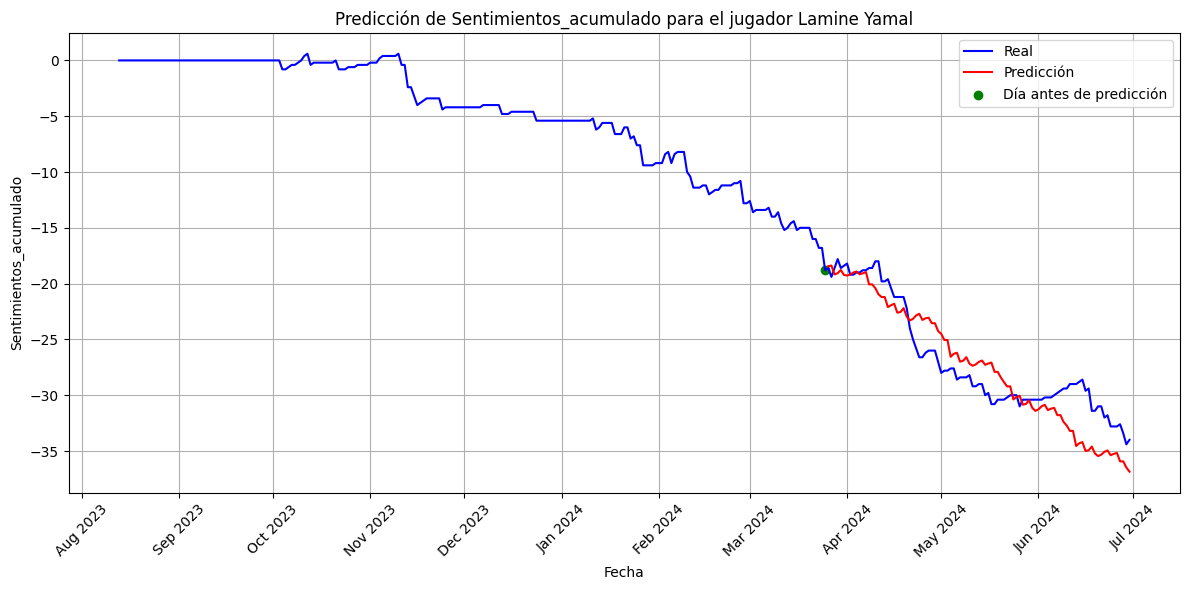

______Todos los días____________
Mean error todos: 2.0208770019496582
Std error todos: 1.3953844754467684
Min error todos: 0.016663880557103994
Max error todos: 5.60295647933895
Median error todos: 1.8452131854962524

______Días de partido___________
Mean error dia partido: 2.1551459717459247
Std error dia partido: 1.4156762932639624
Min error dia partido: 0.17826238501527314
Max error dia partido: 5.60295647933895
Median error dia partido: 2.4044323201570776

______Días antes de partido_____
Mean error dia antes partido: 2.261718139958895
Std error dia antes partido: 1.2732723003453343
Min error dia antes partido: 0.16744290994608235
Max error dia antes partido: 5.507028705206519
Median error dia antes partido: 2.076540156832806


In [121]:
players = df['Player'].unique()

jugador = players[5]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,0),
    'seasonal_order': (1,1,0,20),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

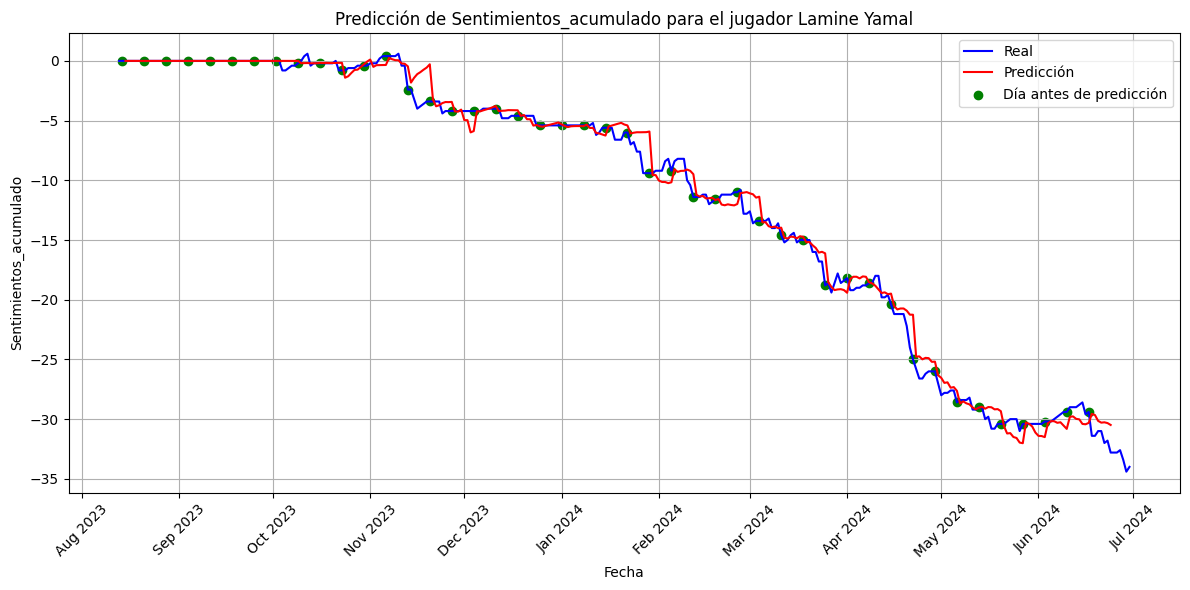

______Todos los días____________
Mean error todos: 0.6226399848343945
Std error todos: 0.7242570460769752
Min error todos: 0.0
Max error todos: 3.7436366926117017
Median error todos: 0.3856706505062668

______Días de partido___________
Mean error dia partido: 0.6814396687197237
Std error dia partido: 0.7550254497211598
Min error dia partido: 0.0
Max error dia partido: 3.431243710359624
Median error dia partido: 0.5001196927093243

______Días antes de partido_____
Mean error dia antes partido: 0.6005184724594963
Std error dia antes partido: 0.5992412424042127
Min error dia antes partido: 0.0
Max error dia antes partido: 2.429185051598612
Median error dia antes partido: 0.39999732537915167


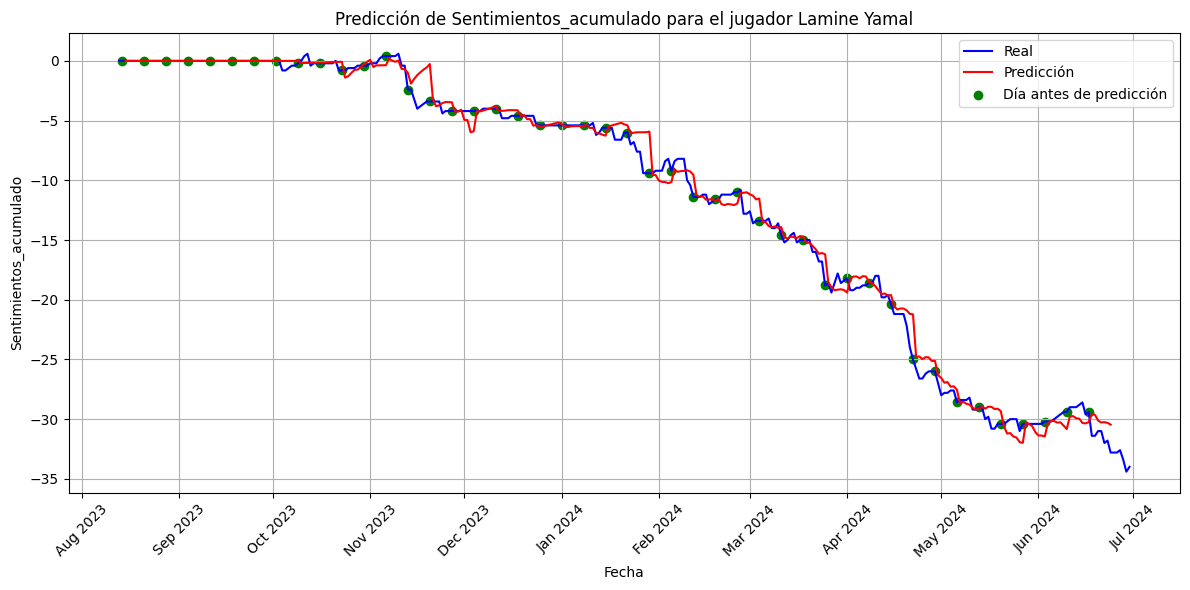

______Todos los días____________
Mean error todos: 0.6202846347969004
Std error todos: 0.7156493324766876
Min error todos: 0.0
Max error todos: 3.7748783882660035
Median error todos: 0.38334037788366615

______Días de partido___________
Mean error dia partido: 0.6854067122921287
Std error dia partido: 0.7485904980194698
Min error dia partido: 0.0
Max error dia partido: 3.424016612877126
Median error dia partido: 0.4714361179792741

______Días antes de partido_____
Mean error dia antes partido: 0.598024376804193
Std error dia antes partido: 0.5927162537660512
Min error dia antes partido: 0.0
Max error dia antes partido: 2.312347788997272
Median error dia antes partido: 0.41855155666102917


In [124]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Lewandowski

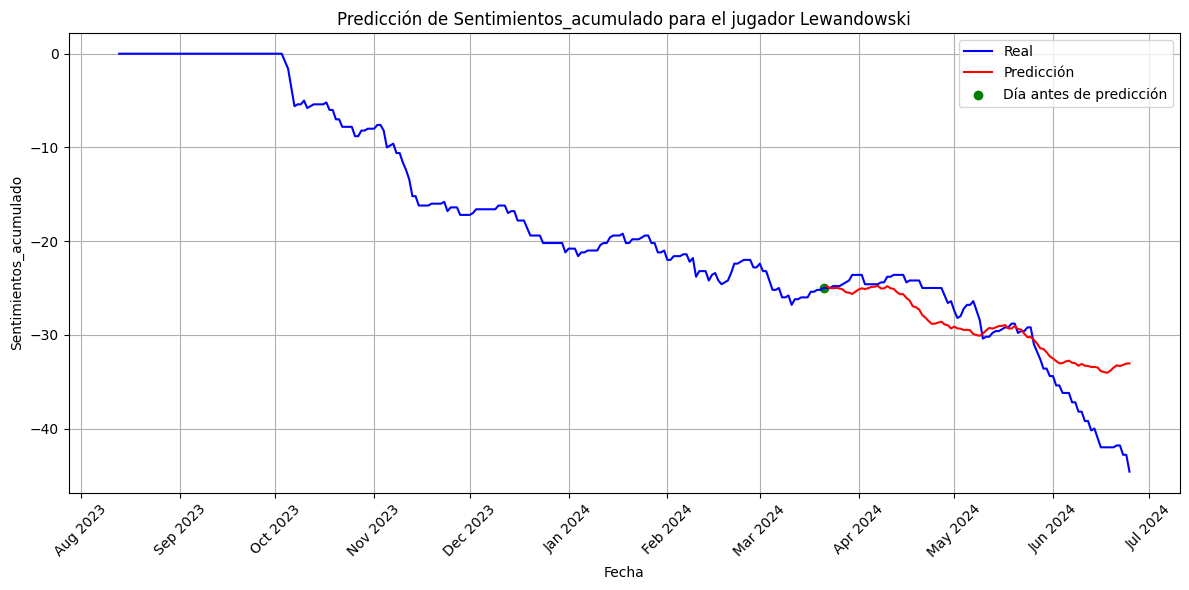

______Todos los días____________
Mean error todos: 2.7209934474311925
Std error todos: 2.661215847130205
Min error todos: 0.010265235549891116
Max error todos: 11.556910610991167
Median error todos: 1.9536042449913928

______Días de partido___________
Mean error dia partido: 2.8455089612120616
Std error dia partido: 3.3826441964185414
Min error dia partido: 0.357383291308615
Max error dia partido: 11.556910610991167
Median error dia partido: 1.8489454616302279

______Días antes de partido_____
Mean error dia antes partido: 2.699694824107843
Std error dia antes partido: 3.0148214031149356
Min error dia antes partido: 0.12578223605898486
Max error dia antes partido: 9.736452460471966
Median error dia antes partido: 1.3221305303390647


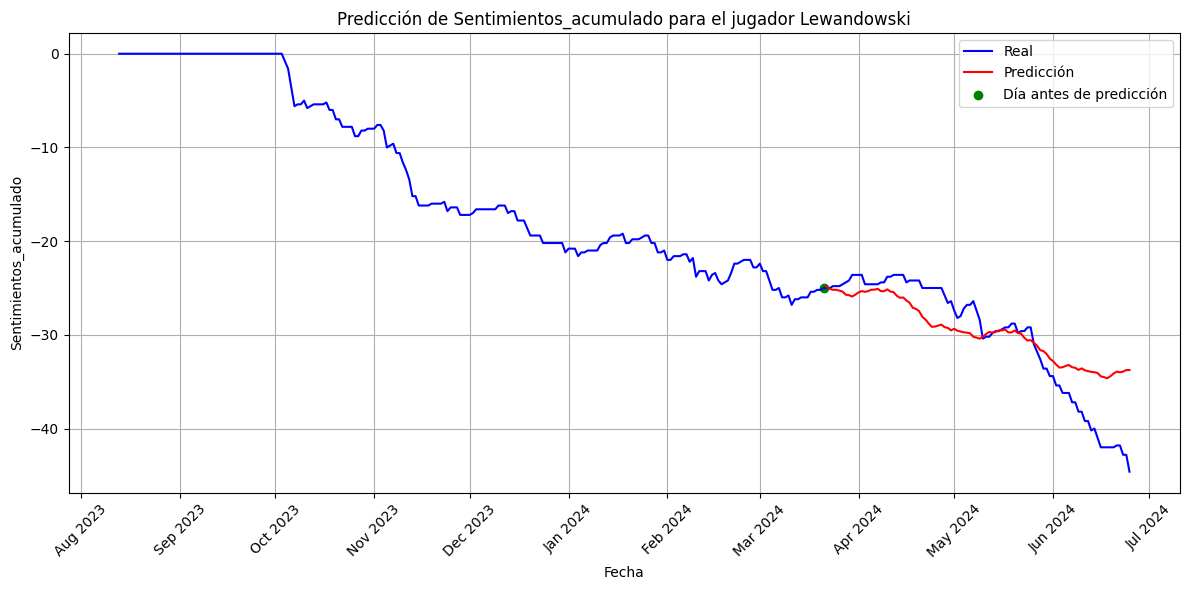

______Todos los días____________
Mean error todos: 2.6987277467250723
Std error todos: 2.432954946631378
Min error todos: 0.010114995163753804
Max error todos: 10.843078748896595
Median error todos: 1.9810366793298861

______Días de partido___________
Mean error dia partido: 2.818126302390445
Std error dia partido: 3.1482193198945425
Min error dia partido: 0.03407279975179023
Max error dia partido: 10.843078748896595
Median error dia partido: 2.120070232431873

______Días antes de partido_____
Mean error dia antes partido: 2.717568620406516
Std error dia antes partido: 2.7606768117121128
Min error dia antes partido: 0.07893112400115498
Max error dia antes partido: 9.043068372997766
Median error dia antes partido: 1.6054575737446388


In [125]:
players = df['Player'].unique()

jugador = players[6]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,40),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

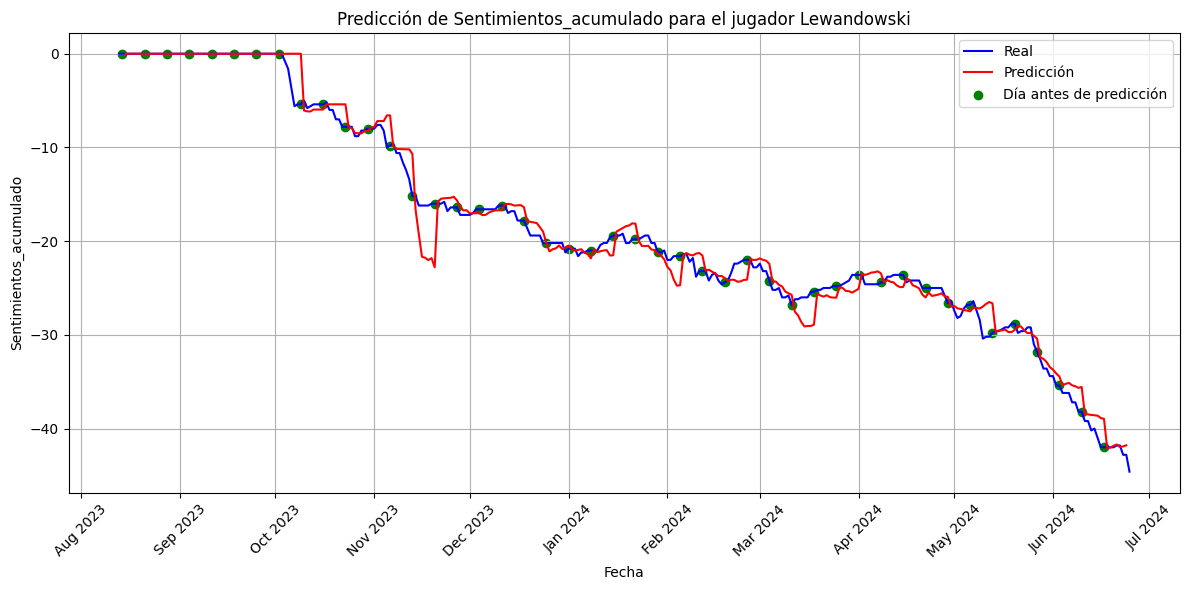

______Todos los días____________
Mean error todos: 0.9640904258438111
Std error todos: 1.1655902722489897
Min error todos: 0.0
Max error todos: 6.784837751563682
Median error todos: 0.6240895872200305

______Días de partido___________
Mean error dia partido: 0.927950535115155
Std error dia partido: 0.906533768811225
Min error dia partido: 0.0
Max error dia partido: 3.6498770360636463
Median error dia partido: 0.7057507860385623

______Días antes de partido_____
Mean error dia antes partido: 0.7751997655342165
Std error dia antes partido: 0.9376729111313784
Min error dia antes partido: 0.0
Max error dia antes partido: 3.7065907307759716
Median error dia antes partido: 0.4140086560464056


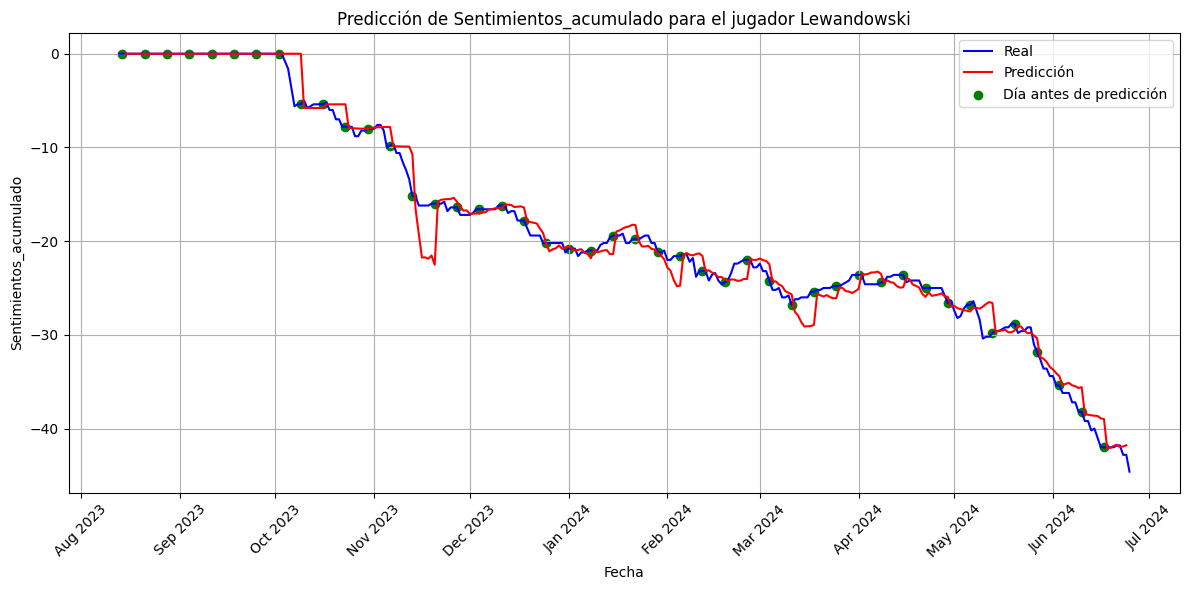

______Todos los días____________
Mean error todos: 0.938428288928012
Std error todos: 1.1510355418241147
Min error todos: 0.0
Max error todos: 6.521514871448947
Median error todos: 0.6326752355227256

______Días de partido___________
Mean error dia partido: 0.8991704156247323
Std error dia partido: 0.9302575491447903
Min error dia partido: 0.0
Max error dia partido: 3.6654647157138207
Median error dia partido: 0.6565017078289515

______Días antes de partido_____
Mean error dia antes partido: 0.7498920594455678
Std error dia antes partido: 0.8868300399470239
Min error dia antes partido: 0.0
Max error dia antes partido: 3.7042398701902464
Median error dia antes partido: 0.44189018585362305


In [126]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,40),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Miguel Gutiérrez

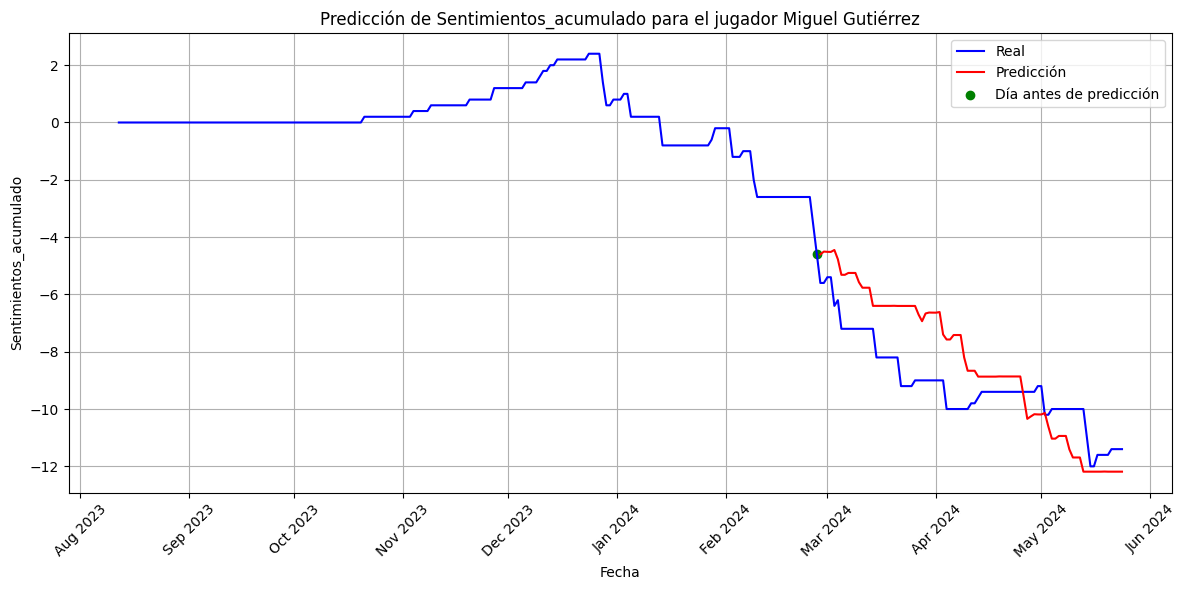

______Todos los días____________
Mean error todos: 1.364711400494683
Std error todos: 0.7544418248687957
Min error todos: 0.06213512805628518
Max error todos: 2.798039843660627
Median error todos: 1.185955284329813

______Días de partido___________
Mean error dia partido: 1.3170465483037175
Std error dia partido: 0.5924258022278234
Min error dia partido: 0.5364106807122688
Max error dia partido: 2.3642459989827724
Median error dia partido: 1.1096988957012037

______Días antes de partido_____
Mean error dia antes partido: 1.1856529442317714
Std error dia antes partido: 0.7276554801062896
Min error dia antes partido: 0.19076397514764665
Max error dia antes partido: 2.367309249802907
Median error dia antes partido: 1.0094966403315024


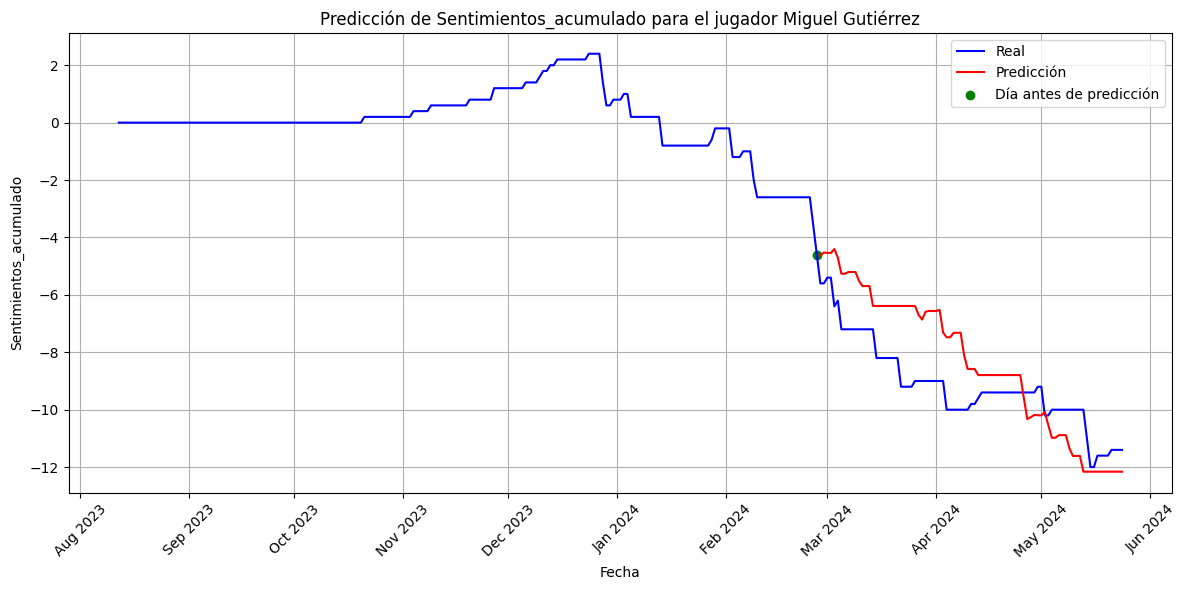

______Todos los días____________
Mean error todos: 1.3891634261287051
Std error todos: 0.7692123364935173
Min error todos: 0.11330567168593397
Max error todos: 2.8133669187374224
Median error todos: 1.2185180261053308

______Días de partido___________
Mean error dia partido: 1.327808683453362
Std error dia partido: 0.6030654832915588
Min error dia partido: 0.6063233862033925
Max error dia partido: 2.4380329781046157
Median error dia partido: 1.0681601106483525

______Días antes de partido_____
Mean error dia antes partido: 1.1901173562873066
Std error dia antes partido: 0.7453335182674108
Min error dia antes partido: 0.18148197547648692
Max error dia antes partido: 2.441676970080313
Median error dia antes partido: 1.0388557087652859


In [127]:
players = df['Player'].unique()

jugador = players[7]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,0),
    'seasonal_order': (1,1,0,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

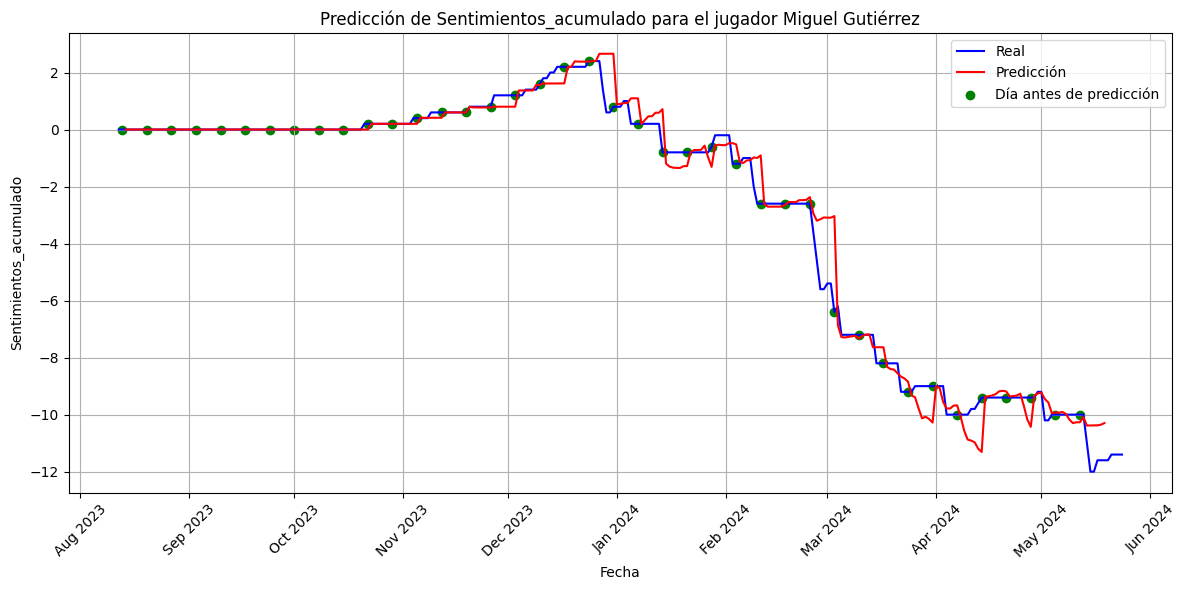

______Todos los días____________
Mean error todos: 0.3059534551403633
Std error todos: 0.5196899500614608
Min error todos: 0.0
Max error todos: 3.364087625544451
Median error todos: 0.08149180880689527

______Días de partido___________
Mean error dia partido: 0.4749197284524979
Std error dia partido: 0.700674224416718
Min error dia partido: 0.0
Max error dia partido: 3.364087625544451
Median error dia partido: 0.1999967480140232

______Días antes de partido_____
Mean error dia antes partido: 0.31952984863064077
Std error dia antes partido: 0.47545814559809196
Min error dia antes partido: 0.0
Max error dia antes partido: 2.309229871472281
Median error dia antes partido: 0.1752444961670495


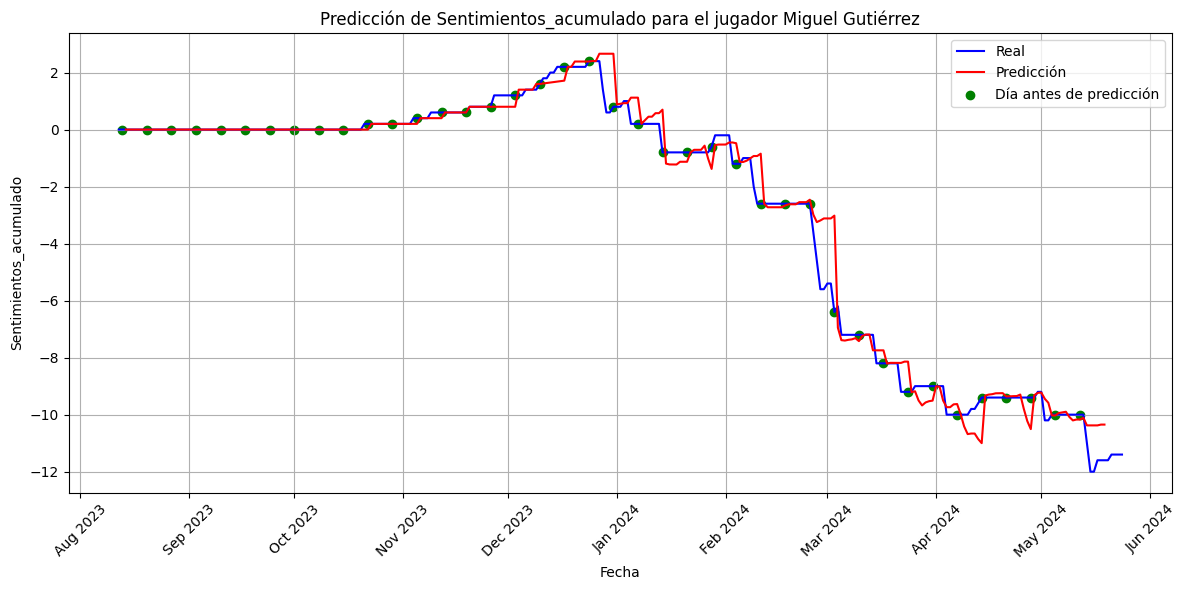

______Todos los días____________
Mean error todos: 0.2877905562130073
Std error todos: 0.5070765969961192
Min error todos: 0.0
Max error todos: 3.38157922118912
Median error todos: 0.07316021971032766

______Días de partido___________
Mean error dia partido: 0.4368831425837439
Std error dia partido: 0.6808573343442255
Min error dia partido: 0.0
Max error dia partido: 3.38157922118912
Median error dia partido: 0.2

______Días antes de partido_____
Mean error dia antes partido: 0.28521968771675626
Std error dia antes partido: 0.4350605407535843
Min error dia antes partido: 0.0
Max error dia antes partido: 2.2829024037435297
Median error dia antes partido: 0.15811216353243118


In [129]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Mikel Merino

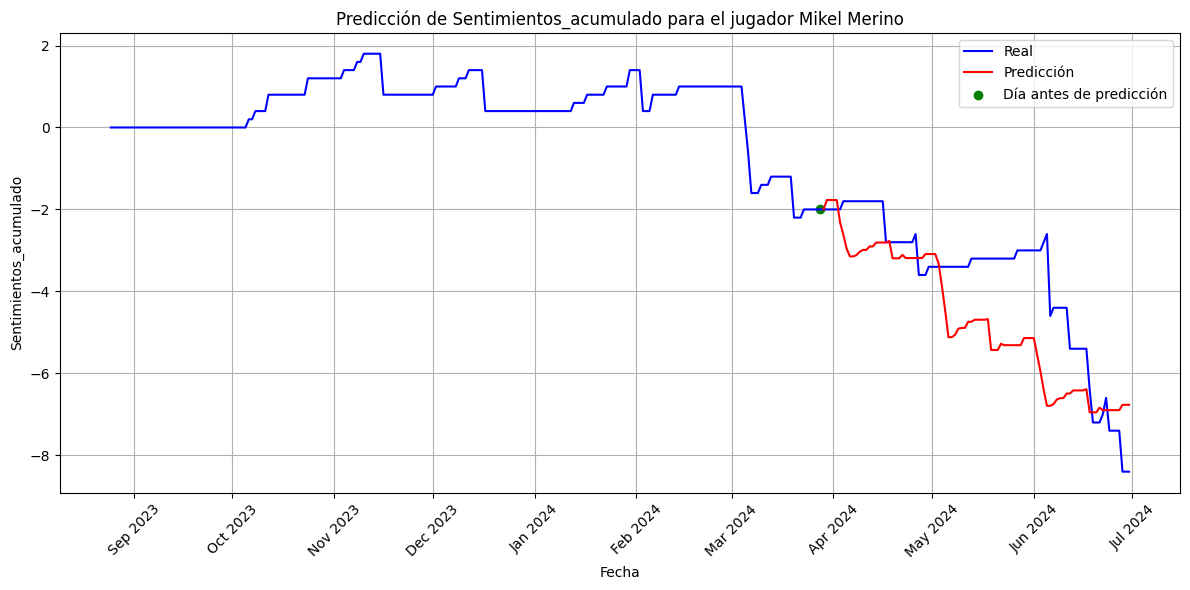

______Todos los días____________
Mean error todos: 1.2229162871320474
Std error todos: 0.8532350510857544
Min error todos: 0.0
Max error todos: 4.1929778237386905
Median error todos: 1.1280076593184627

______Días de partido___________
Mean error dia partido: 0.9447123422706696
Std error dia partido: 0.6228799460803374
Min error dia partido: 0.23018259120921125
Max error dia partido: 2.231026636810302
Median error dia partido: 0.797467558517353

______Días antes de partido_____
Mean error dia antes partido: 0.8082092653163547
Std error dia antes partido: 0.5621750024824177
Min error dia antes partido: 0.08096342897973896
Max error dia antes partido: 1.631518073223762
Median error dia antes partido: 0.7053837436396757


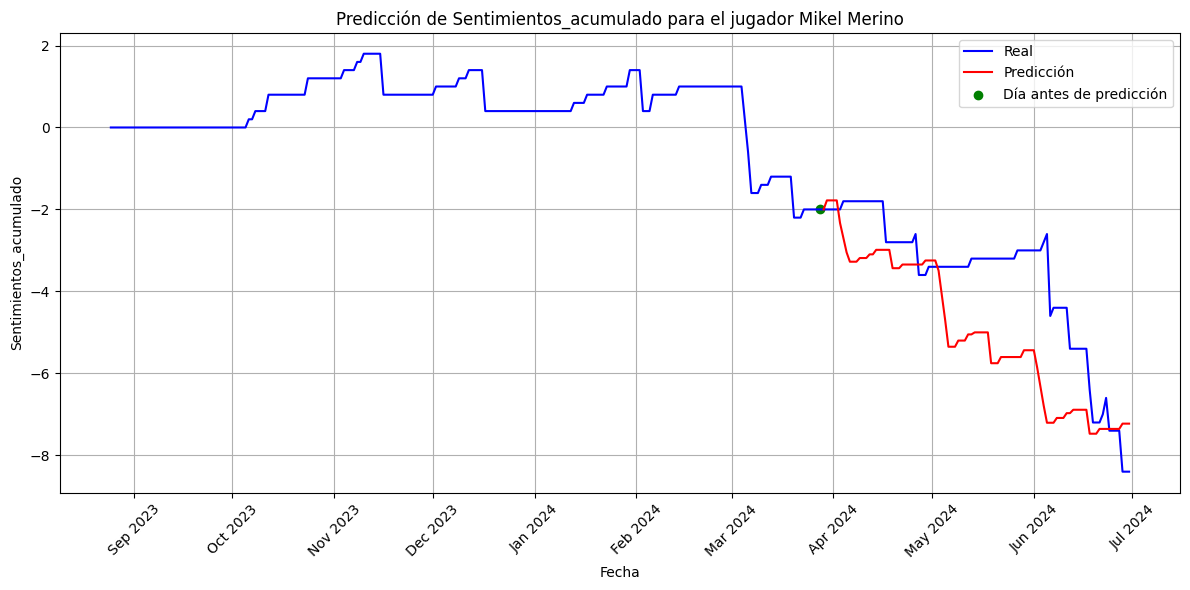

______Todos los días____________
Mean error todos: 1.3989143372979036
Std error todos: 0.9907855693711269
Min error todos: 5.867750729748877e-12
Max error todos: 4.605972626621671
Median error todos: 1.3860952626685137

______Días de partido___________
Mean error dia partido: 1.0552590202305696
Std error dia partido: 0.7294353003801122
Min error dia partido: 0.043213534966212386
Max error dia partido: 2.553253400621534
Median error dia partido: 0.958467867836863

______Días antes de partido_____
Mean error dia antes partido: 0.9776842500087106
Std error dia antes partido: 0.6063970211509052
Min error dia antes partido: 0.09306697521728768
Max error dia antes partido: 1.8005727623608188
Median error dia antes partido: 0.9645234212669371


In [130]:
players = df['Player'].unique()

jugador = players[8]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,0),
    'seasonal_order': (1,1,0,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

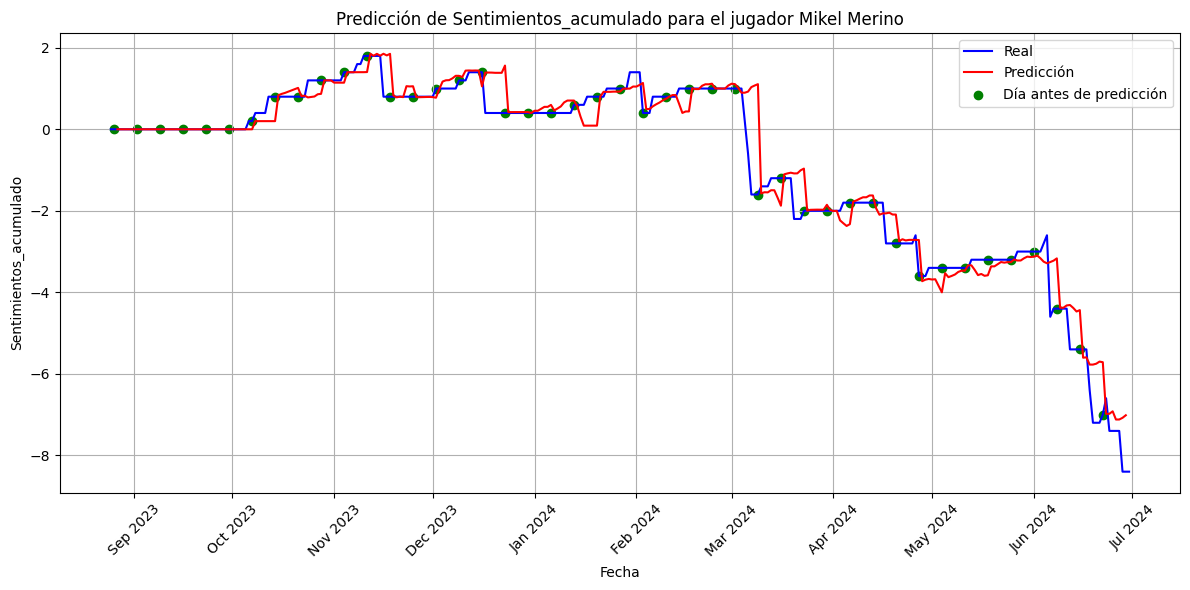

______Todos los días____________
Mean error todos: 0.2785559197090062
Std error todos: 0.4176141388685318
Min error todos: 0.0
Max error todos: 2.7070624074593717
Median error todos: 0.1176284079023916

______Días de partido___________
Mean error dia partido: 0.3533293882745933
Std error dia partido: 0.5047589118036881
Min error dia partido: 0.0
Max error dia partido: 2.7070624074593717
Median error dia partido: 0.16274040196961037

______Días antes de partido_____
Mean error dia antes partido: 0.35166526040320545
Std error dia antes partido: 0.503382446042396
Min error dia antes partido: 0.0
Max error dia antes partido: 2.673447741283181
Median error dia antes partido: 0.19396981512671613


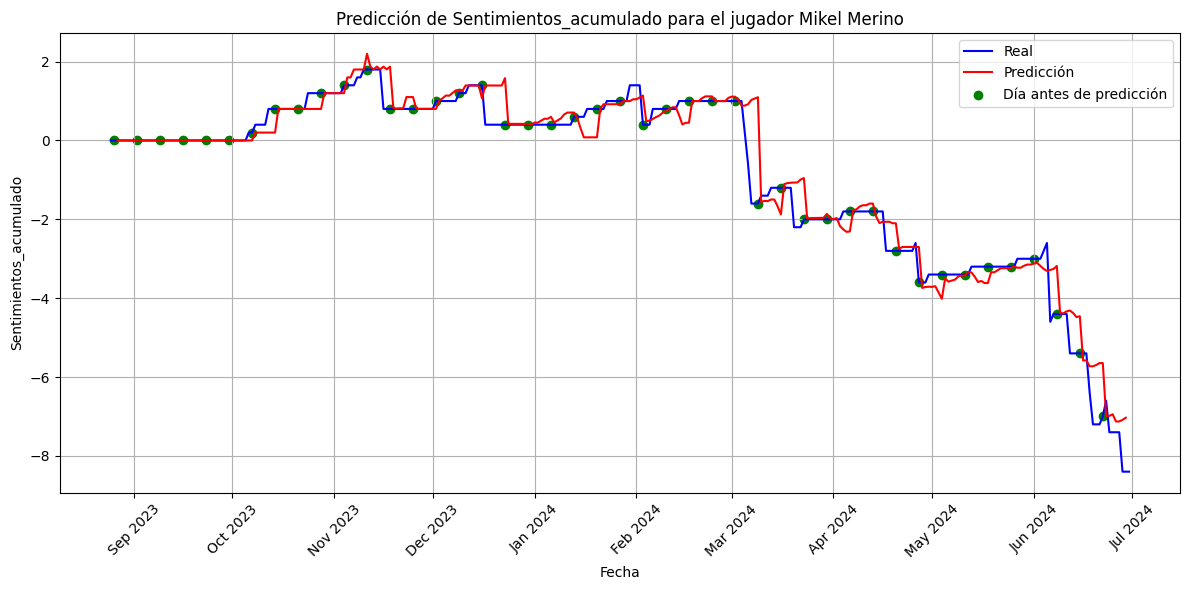

______Todos los días____________
Mean error todos: 0.27536327804714095
Std error todos: 0.4213062788491484
Min error todos: 0.0
Max error todos: 2.696434898922279
Median error todos: 0.11672816567785749

______Días de partido___________
Mean error dia partido: 0.34386599010775887
Std error dia partido: 0.5108432999849506
Min error dia partido: 0.0
Max error dia partido: 2.696434898922279
Median error dia partido: 0.14231756293302755

______Días antes de partido_____
Mean error dia antes partido: 0.34680803514924285
Std error dia antes partido: 0.507292689009353
Min error dia antes partido: 0.0
Max error dia antes partido: 2.6625912124398914
Median error dia antes partido: 0.19725005758546565


In [131]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Morata

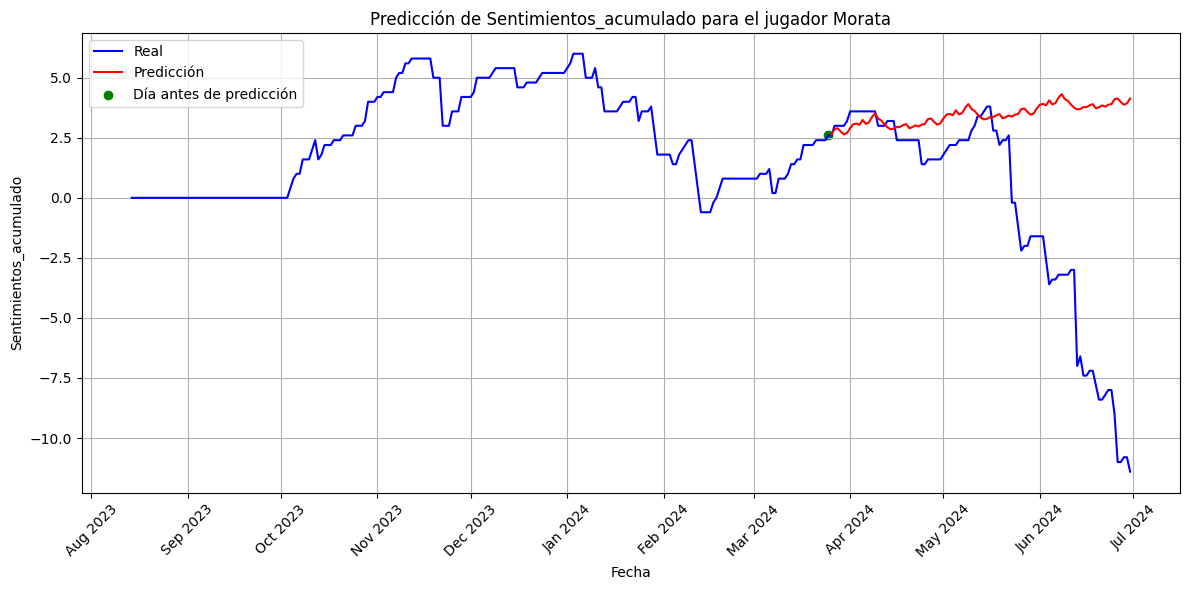

______Todos los días____________
Mean error todos: 4.079504397028406
Std error todos: 4.663542018965427
Min error todos: 0.04403118119059979
Max error todos: 15.5365130438547
Median error todos: 1.4469700454361552

______Días de partido___________
Mean error dia partido: 4.990518723022034
Std error dia partido: 5.652479071240835
Min error dia partido: 0.06689096167663688
Max error dia partido: 15.5365130438547
Median error dia partido: 1.263130620165879

______Días antes de partido_____
Mean error dia antes partido: 4.635477015513626
Std error dia antes partido: 5.444049736518571
Min error dia antes partido: 0.06252519505807053
Max error dia antes partido: 14.73474413100102
Median error dia antes partido: 0.9651132815469734


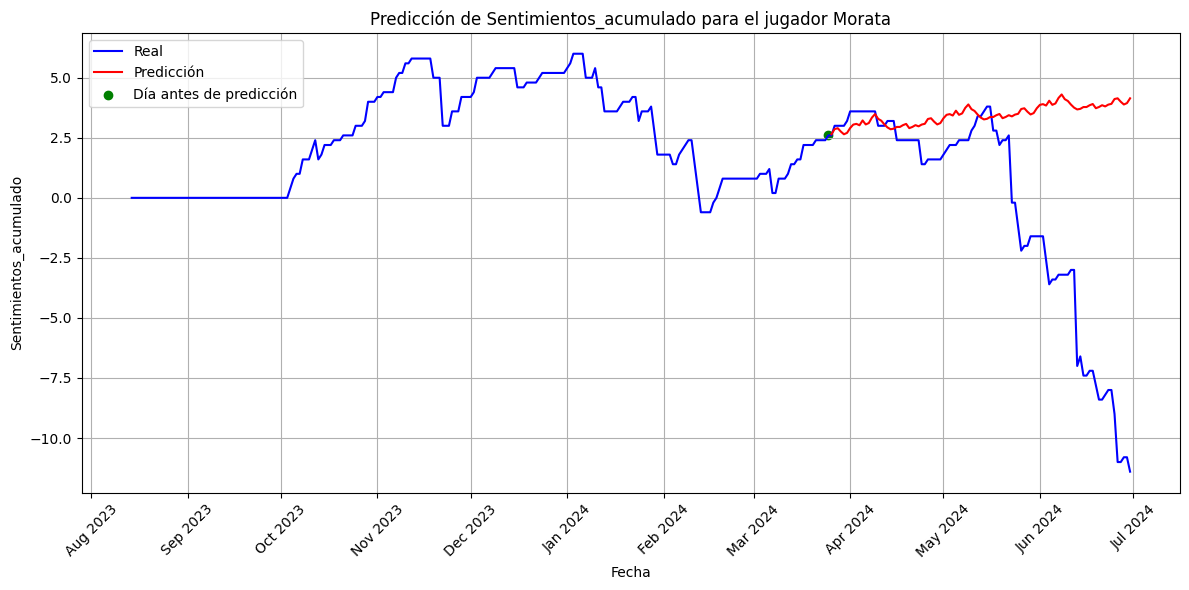

______Todos los días____________
Mean error todos: 4.081396056975249
Std error todos: 4.664116580626772
Min error todos: 0.04973403185412373
Max error todos: 15.544089293944966
Median error todos: 1.455819744442254

______Días de partido___________
Mean error dia partido: 4.9920176717339535
Std error dia partido: 5.657423970558006
Min error dia partido: 0.0657543114711574
Max error dia partido: 15.544089293944966
Median error dia partido: 1.2594776344039949

______Días antes de partido_____
Mean error dia antes partido: 4.6380657968005865
Std error dia antes partido: 5.445509213058752
Min error dia antes partido: 0.057893021255891686
Max error dia antes partido: 14.743873781572589
Median error dia antes partido: 0.9629620101586418


In [132]:
players = df['Player'].unique()

jugador = players[9]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

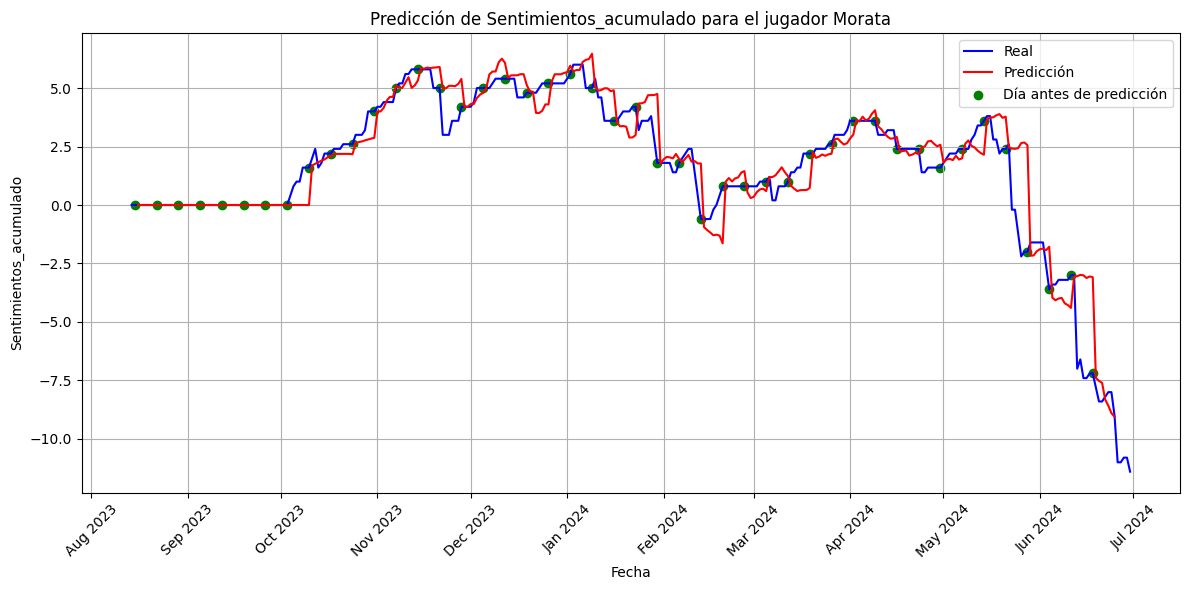

______Todos los días____________
Mean error todos: 0.6432069746875305
Std error todos: 0.8494518497841006
Min error todos: 0.0
Max error todos: 4.848763664797328
Median error todos: 0.35662771264622917

______Días de partido___________
Mean error dia partido: 0.8072916860373464
Std error dia partido: 0.8876478762084583
Min error dia partido: 0.0
Max error dia partido: 4.394702268044785
Median error dia partido: 0.5463154855131471

______Días antes de partido_____
Mean error dia antes partido: 0.6268901979038158
Std error dia antes partido: 0.7368115162311474
Min error dia antes partido: 0.0
Max error dia antes partido: 3.613008553731633
Median error dia antes partido: 0.38252006856046306


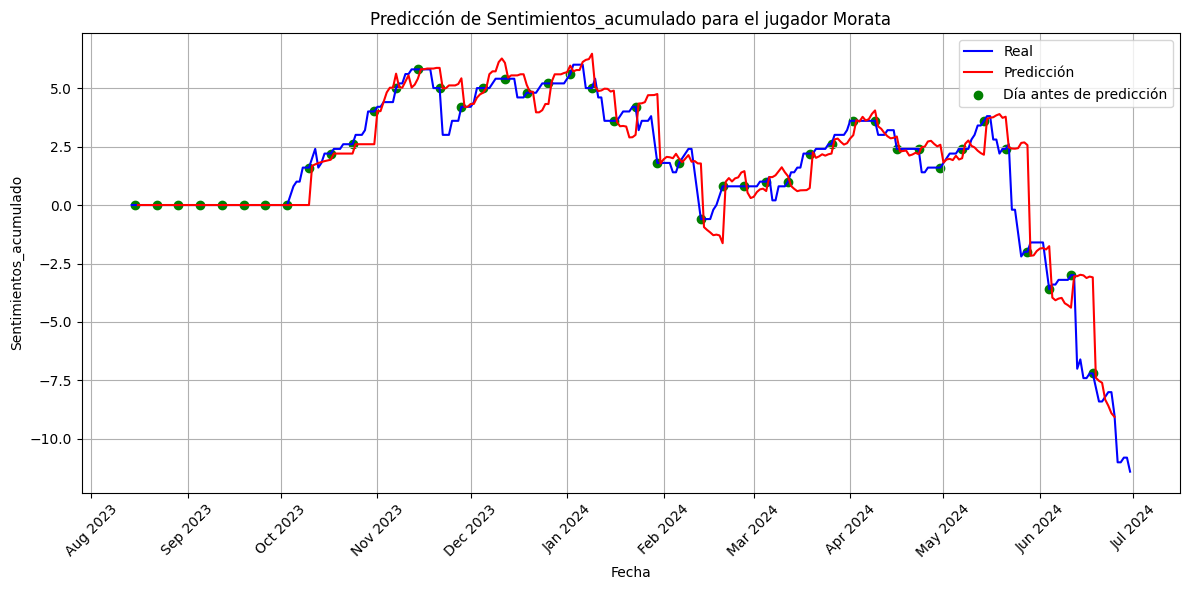

______Todos los días____________
Mean error todos: 0.6496565503208249
Std error todos: 0.8503939473050847
Min error todos: 0.0
Max error todos: 4.855011833012707
Median error todos: 0.3823965654943349

______Días de partido___________
Mean error dia partido: 0.8195508869492429
Std error dia partido: 0.8882003202135965
Min error dia partido: 0.0
Max error dia partido: 4.392832466149562
Median error dia partido: 0.593662566864467

______Días antes de partido_____
Mean error dia antes partido: 0.6361790522566048
Std error dia antes partido: 0.7366161084727962
Min error dia antes partido: 0.0
Max error dia antes partido: 3.617948503742292
Median error dia antes partido: 0.40578865784718077


In [133]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Nico Williams

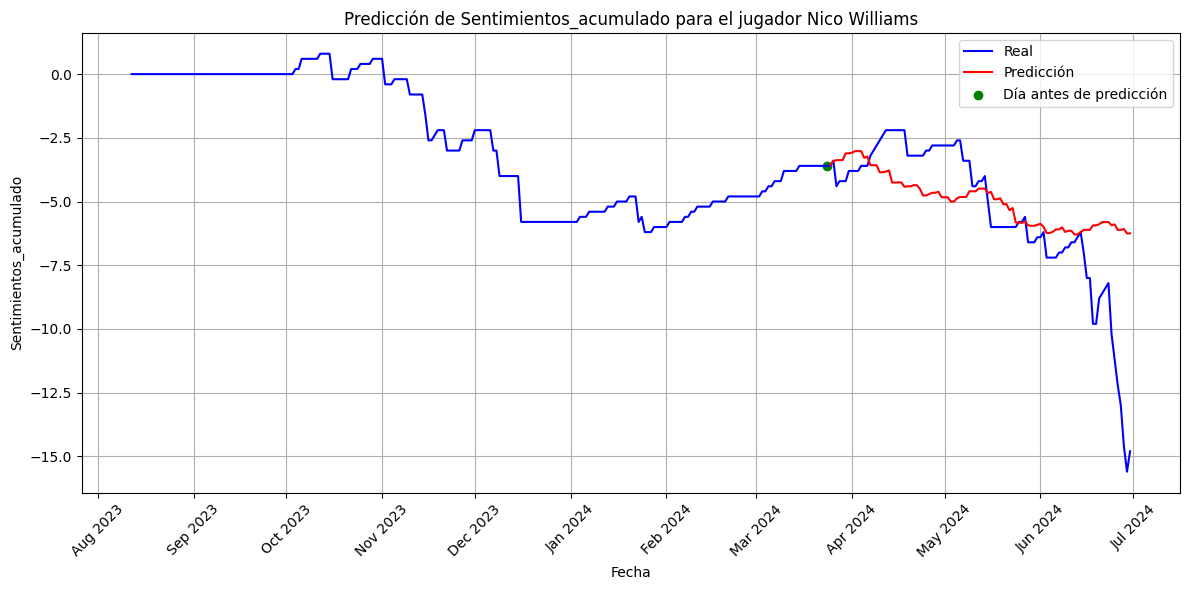

______Todos los días____________
Mean error todos: 1.5826899422614173
Std error todos: 1.7620267681522854
Min error todos: 0.000719984150827635
Max error todos: 9.35033714171115
Median error todos: 1.0902845412753035

______Días de partido___________
Mean error dia partido: 2.1012048900661697
Std error dia partido: 2.312049705364016
Min error dia partido: 0.0271947744266825
Max error dia partido: 8.5503371037128
Median error dia partido: 1.5295836435638903

______Días antes de partido_____
Mean error dia antes partido: 2.2224154288885956
Std error dia antes partido: 2.6211044954386136
Min error dia antes partido: 0.0020230167522541365
Max error dia antes partido: 9.35033714171115
Median error dia antes partido: 1.6437306817807367


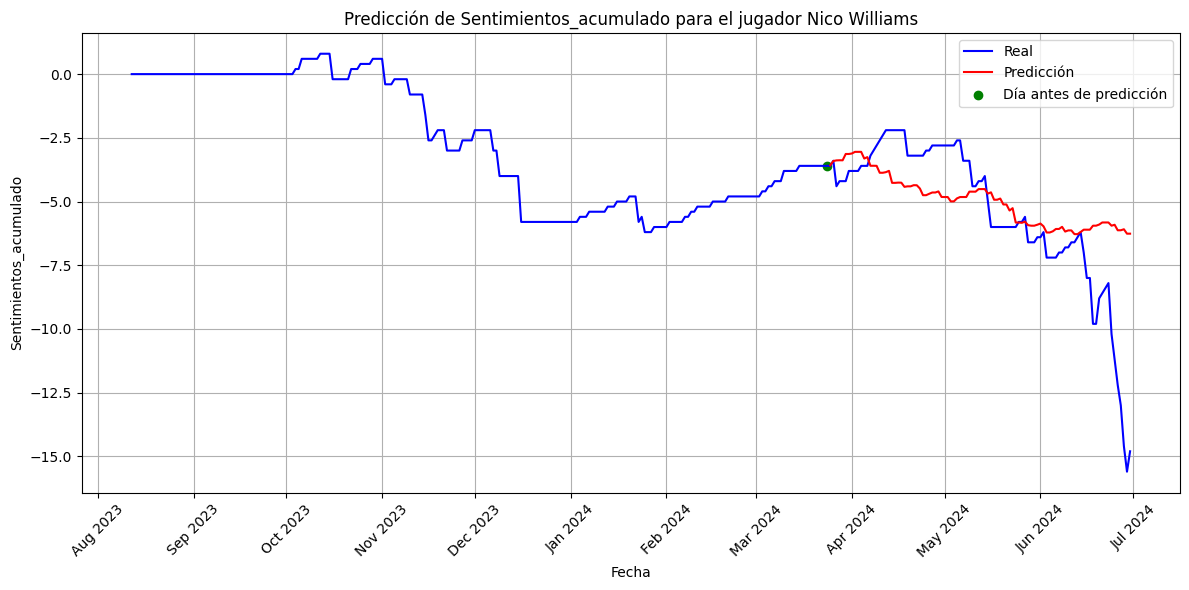

______Todos los días____________
Mean error todos: 1.5817009342362673
Std error todos: 1.7579235669504476
Min error todos: 0.00482663055786503
Max error todos: 9.33898766821909
Median error todos: 1.071076157994728

______Días de partido___________
Mean error dia partido: 2.0995923419482176
Std error dia partido: 2.307758757601232
Min error dia partido: 0.02430082304938086
Max error dia partido: 8.53898763973665
Median error dia partido: 1.5243535701164395

______Días antes de partido_____
Mean error dia antes partido: 2.2193936286643363
Std error dia antes partido: 2.6169618667953696
Min error dia antes partido: 0.00482663055786503
Max error dia antes partido: 9.33898766821909
Median error dia antes partido: 1.6460829241465642


In [134]:
players = df['Player'].unique()

jugador = players[10]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (2,1,1),
    'seasonal_order': (2,1,1,40),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

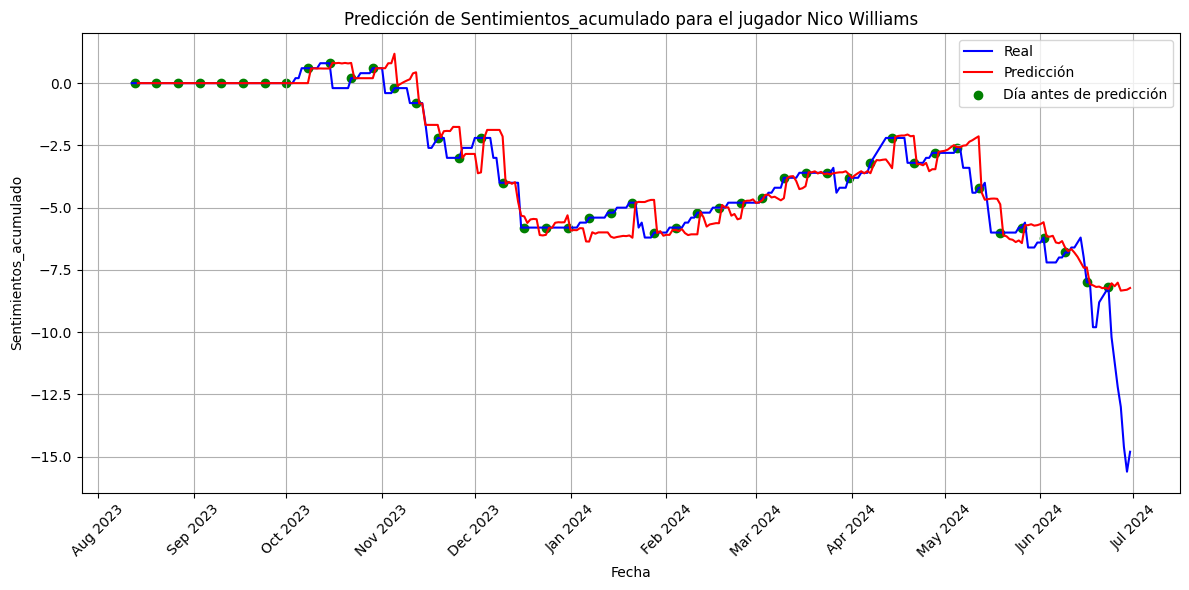

______Todos los días____________
Mean error todos: 0.5278029835872874
Std error todos: 0.8452283376210505
Min error todos: 0.0
Max error todos: 7.30525865717237
Median error todos: 0.2273852731261068

______Días de partido___________
Mean error dia partido: 0.8321374910238841
Std error dia partido: 1.1346134970632415
Min error dia partido: 0.0
Max error dia partido: 6.575445762197331
Median error dia partido: 0.6113010261046343

______Días antes de partido_____
Mean error dia antes partido: 0.8838001913315072
Std error dia antes partido: 1.2691228260327996
Min error dia antes partido: 0.0
Max error dia antes partido: 7.30525865717237
Median error dia antes partido: 0.6244590403308994


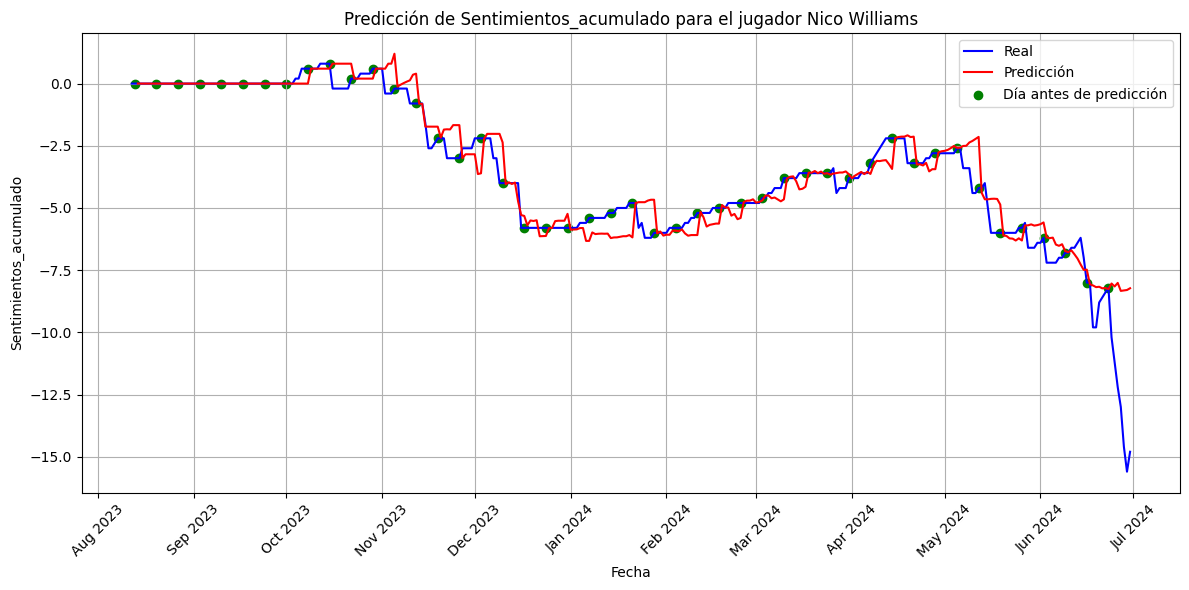

______Todos los días____________
Mean error todos: 0.5236125585062219
Std error todos: 0.8442316334756822
Min error todos: 0.0
Max error todos: 7.302685557893772
Median error todos: 0.22841743356750266

______Días de partido___________
Mean error dia partido: 0.8293774598518993
Std error dia partido: 1.1361197091794155
Min error dia partido: 0.0
Max error dia partido: 6.573017176414643
Median error dia partido: 0.6000000000000001

______Días antes de partido_____
Mean error dia antes partido: 0.8771152556658247
Std error dia antes partido: 1.268297008838317
Min error dia antes partido: 0.0
Max error dia antes partido: 7.302685557893772
Median error dia antes partido: 0.6359369926514677


In [136]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

### Vinicius

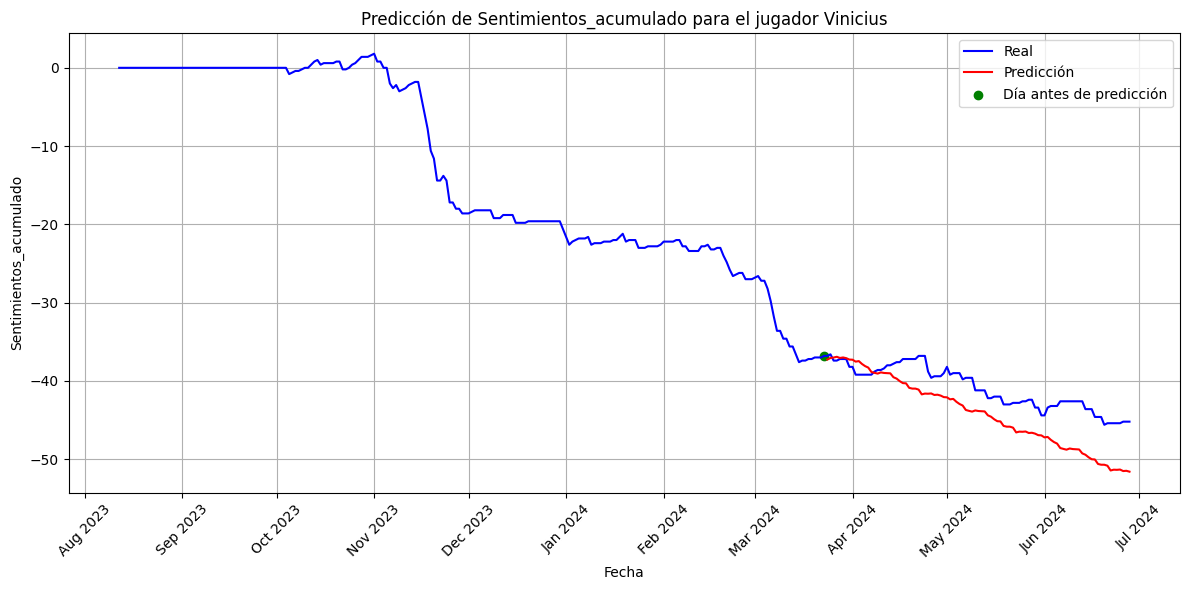

______Todos los días____________
Mean error todos: 3.395323070318359
Std error todos: 1.9035654471594787
Min error todos: 0.11161370054327335
Max error todos: 6.652612833577393
Median error todos: 3.2901948076985263

______Días de partido___________
Mean error dia partido: 3.2709317882092748
Std error dia partido: 1.6322053130437055
Min error dia partido: 0.4602798941147057
Max error dia partido: 6.388663820678495
Median error dia partido: 3.0763133409297936

______Días antes de partido_____
Mean error dia antes partido: 3.1696864839769674
Std error dia antes partido: 1.6248579675684809
Min error dia antes partido: 0.16576875796133805
Max error dia antes partido: 6.277749457725193
Median error dia antes partido: 2.831964184421132


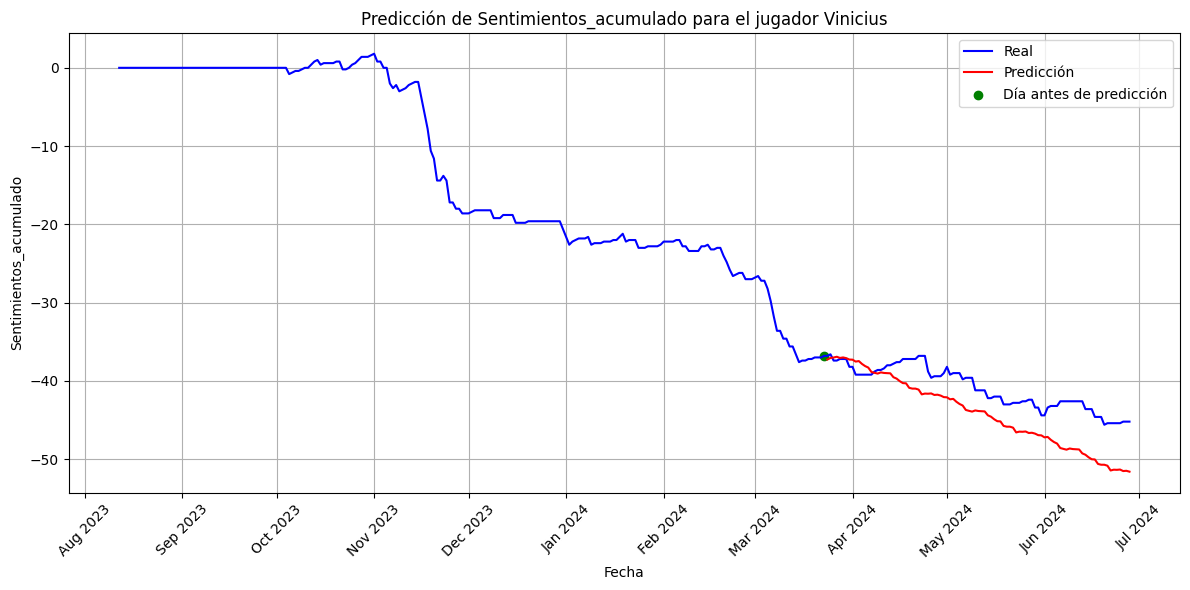

______Todos los días____________
Mean error todos: 3.397418292774672
Std error todos: 1.9042550552644435
Min error todos: 0.11148489575228382
Max error todos: 6.655342120549804
Median error todos: 3.2905642070123093

______Días de partido___________
Mean error dia partido: 3.2729422139399724
Std error dia partido: 1.6329046839596713
Min error dia partido: 0.46133138348748304
Max error dia partido: 6.392371195194563
Median error dia partido: 3.079215728970439

______Días antes de partido_____
Mean error dia antes partido: 3.172005065986654
Std error dia antes partido: 1.6255834605236101
Min error dia antes partido: 0.1653181798064125
Max error dia antes partido: 6.281473762965298
Median error dia antes partido: 2.8348664794257985


In [137]:
players = df['Player'].unique()

jugador = players[12]
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size' : 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

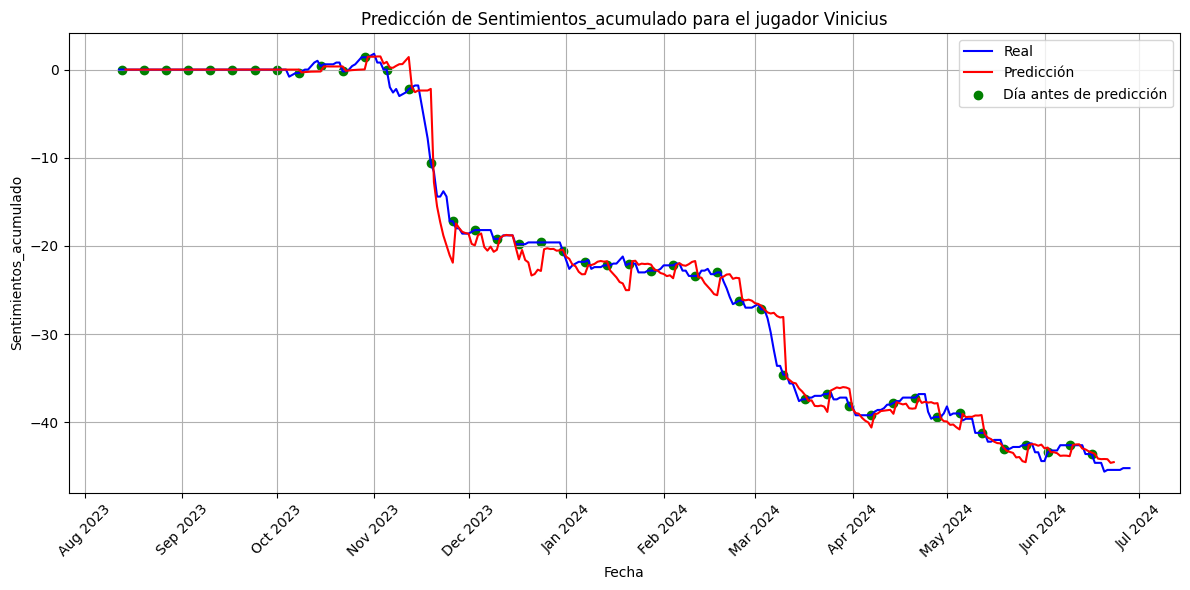

______Todos los días____________
Mean error todos: 0.9574700248498668
Std error todos: 1.1963992235637817
Min error todos: 0.0
Max error todos: 8.412558353210281
Median error todos: 0.6096223263726799

______Días de partido___________
Mean error dia partido: 1.2189116248655472
Std error dia partido: 1.3220374301088655
Min error dia partido: 0.0
Max error dia partido: 6.545731596846803
Median error dia partido: 0.8732389297925067

______Días antes de partido_____
Mean error dia antes partido: 1.0522000146351145
Std error dia antes partido: 1.1778666164455336
Min error dia antes partido: 0.0
Max error dia antes partido: 5.487688083906722
Median error dia antes partido: 0.6675829956595771


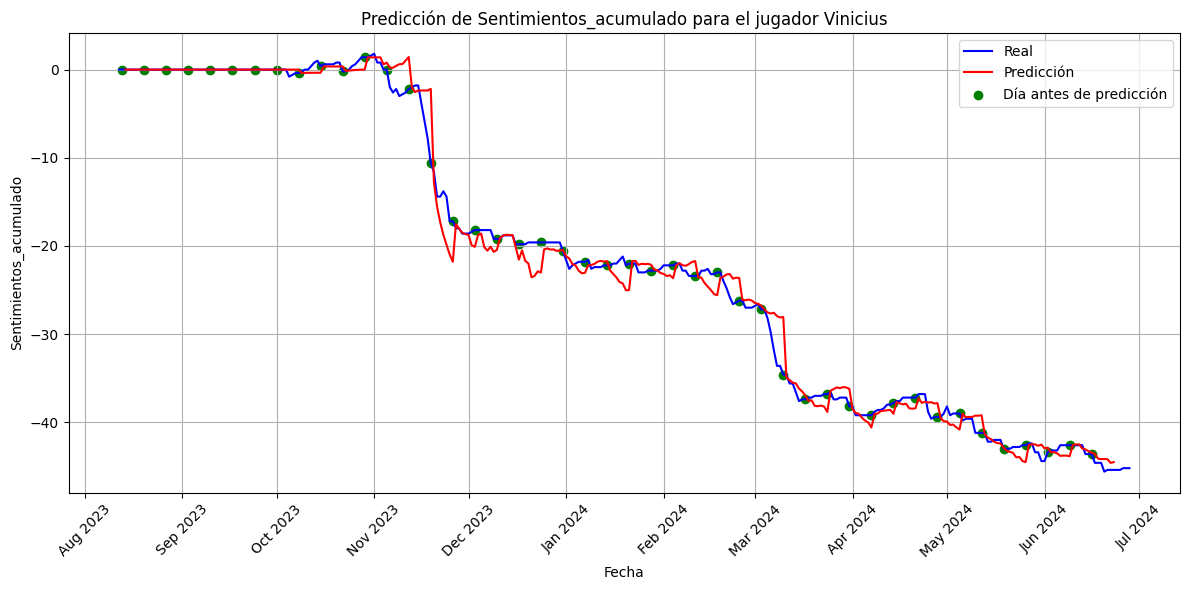

______Todos los días____________
Mean error todos: 0.9625038812046832
Std error todos: 1.1989754057345468
Min error todos: 0.0
Max error todos: 8.41288395200315
Median error todos: 0.590878986945519

______Días de partido___________
Mean error dia partido: 1.2182153368311344
Std error dia partido: 1.3223341842975918
Min error dia partido: 0.0
Max error dia partido: 6.545936792438518
Median error dia partido: 0.8014047106007602

______Días antes de partido_____
Mean error dia antes partido: 1.0515818112865563
Std error dia antes partido: 1.179600809355545
Min error dia antes partido: 0.0
Max error dia antes partido: 5.48785099440035
Median error dia antes partido: 0.6546484728194351


In [138]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'Sentimientos_acumulado',
    'exog': 'last_performance',
    'exog_options': 'no_future',
    'pred_options': 'step',
    'step': 7 
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)